In [9]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import system #,container, setup
from scipy.signal import find_peaks

def execute_freq_sens(mys,T_scan_set=[],Amin=0, Amax=0, Ton=0,ht_threshold=0.01, recovery_threshold=0.95):

    traj = []
    tvecs = []
    ht = []
    rt=[]
    recovery_traj = []
    for j, T in enumerate(T_scan_set): 
        ht_,rt_ = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold, recovery_threshold=recovery_threshold)
        ht.append(ht_)
        rt.append(rt_)
        print("A",Amax,"T",T,ht_,rt_)
        traj.append(mys.computational_data["trajectory"])
        tvecs.append(mys.computational_data["tvec"])
        recovery_traj.append(mys.computational_data["recovery_trajectory"])
    return [tvecs,traj, recovery_traj,ht,rt]

def execute_recovery_envelope(mys, height_peaks=0.001, T_scan_set=[],Amin=0, Amax=0, Ton=0,ht_threshold=0.01, recovery_threshold=0.95):
    peak_norm_Ts = []
    tperturblist_Ts = []
    for T in T_scan_set:
        ht, rt = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold,recovery_threshold=recovery_threshold)
        #tperturblist=np.linspace(T,rt,40) #times after habituation at which perturbation is applied, starting always from habituation time
        tperturblist = np.logspace(np.log10(T), np.log10(rt), 25, endpoint=True)
        tperturblist_Ts.append(tperturblist)
        tvec=mys.computational_data["tvec"]
        htstep=mys.computational_data["habituation_time_step"]
       # trajectory=mys.computational_data["trajectory"][:htstep,:]
       # habituation_time=mys.computational_data["habituation_time"]
        times_envelope = []
        peaks_envelope = []
        for t in tperturblist:
            tvecr,recovery_trajectory=mys.integrate_posthabituation_atAmin(tend=t)
            perturbational_tvec, perturbational_trajectory = mys.apply_singlestimulus(recovery_trajectory[-1])
            output_var = perturbational_trajectory[:,mys.output_variable]
            peak, _ = find_peaks(output_var, height=height_peaks) #, height=0
            lista = output_var[peak]
            lista_times = perturbational_tvec[peak]
            peaks_envelope.append(lista[-1])
            
            all_tvec=tvec[:htstep].copy()
            all_tvec=np.concatenate((all_tvec,tvecr))
            times_envelope.append(lista_times[-1]+all_tvec[-1])
        peak_norm = np.array(peaks_envelope)/mys.computational_data['peaks_level'][0]
        peak_norm_Ts.append(peak_norm)
    return [tperturblist_Ts, peak_norm_Ts]


def execute_int_sens(mys,A_scan_set=[],Amin=0,T=0, Ton=0,ht_threshold=0.01, recovery_threshold=0.95):
    
    traj = []
    tvecs = []
    ht = []
    rt=[]
    recovery_traj = []
    for Amax in A_scan_set: 
        ht_,rt_ = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold, recovery_threshold=recovery_threshold)
        ht.append(ht_)
        rt.append(rt_)
        print("T",T, "A",Amax,ht_,rt_)
        traj.append(mys.computational_data["trajectory"])
        tvecs.append(mys.computational_data["tvec"])
        recovery_traj.append(mys.computational_data["recovery_trajectory"])
    return [tvecs,traj, recovery_traj,ht,rt]

def plot_trajectories(tvecs, traj, recovery_traj,ht,rt, idxs=dict(), T_scan_set=[], A_scan_set=[],variables_toplot=["I1", "M1", "R1", "I2", "M2"], 
                      Ms_toplot=["M1","M2"],kind="freqs",offsets=[0.95,1,1.05],colors=[],steps_per_time=100,zorder=[1,2,3],xlimrec=0,ylims=0,savepath=None):
    if not kind in ["freqs", "ints"]:
        raise ValueError("kind should be freqs or ints")
    
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 5))
    vartitles={"I1":"$I_1$", "I2":"$I_2$", "M1":"$M_1$", "M2":"$M_2$", "R1":"$R_1$", "R2":"$R_2$", "Ri":"$R_i$", "Rr":"$R_r$", "Ra":"$R_a$"}
    axes_l=[axes[0][1], axes[0][2], axes[1][0], axes[1][1], axes[1][2]]
    
    for i in range(3): #for the 3 freq or is
    
        #stimulus:
        ax = axes[0][0] 
        if kind=="freqs":
            offset=offsets[i]
            T=T_scan_set[i]
            if len(A_scan_set)!=1:
                raise ValueError("for freqs only 1 intensity should be given")
            x_t_stimuli=np.arange(0,ht[i]*T_scan_set[i]+ht[i],T_scan_set[i]) #time points at which the stimuli are applied
            ax.scatter(x_t_stimuli,[A_scan_set[0]*offset]*len(x_t_stimuli),marker=".",color=colors[i],s=2)
        else:
            if len(T_scan_set)!=1:
                raise ValueError("for ints only 1 frequency should be given")
            T=T_scan_set[0]
            x_t_stimuli=np.arange(0,ht[i]*T+ht[i],T)
            ax.scatter(x_t_stimuli,[A_scan_set[i]]*len(x_t_stimuli),marker=".",color=colors[i],s=2)
        ax.set_xlabel("time (a.u.)")
        ax.set_ylabel("S")
        if i==2:
            ax.set_ylim(0,ylims)
        
        
        #now plot the rest    
        for v,variable in enumerate(variables_toplot):
            ax=axes_l[v]
            if variable in idxs.keys():
                idx=idxs[variable]

                x = tvecs[i][:ht[i]*T*steps_per_time]/T+1 # no of stimuli
                y = traj[i][:ht[i]*T*steps_per_time,idx] #trajectory data for this freq or intensity
                ax.plot(x, y, color = colors[i],zorder=zorder[i])

                ax.set_title(vartitles[variable])
                ax.set_ylabel("active fraction")
                ax.set_xlabel('no. of stimuli')
                if i==2:
                    ax.set_ylim(0,)

        # M recovery
        for v,variable in enumerate(Ms_toplot):
            if variable in idxs.keys():
                ax = axes[v][3]
                y = recovery_traj[i][:,idxs[variable]]
                x = np.arange(0,len(y))/steps_per_time
                ax.plot(x, y, color = colors[i])
                ax.set_title("%s (recovery)"%vartitles[variable])
                ax.set_xlim(0,xlimrec)
                ax.set_xlabel('post-hab. time (a.u.)')
                if i==2:
                     ax.set_ylim(0,)
    for ax in axes.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    plt.tight_layout()
    
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()
        
    
def plot_freq_or_is(tvecs, traj, recovery_traj,ht,rt, varname="$R_2$",idx=-1, T_scan_set=[], A_scan_set=[], 
                      kind="freqs",colors=[],steps_per_time=100,zorder=[1,2,3],savepath=None):
    if not kind in ["freqs", "ints"]:
        raise ValueError("kind should be freqs or ints")
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
    for i in range(0,3):
        if kind=="freqs":
            title="frequency sensitivity"
            y = traj[i][:ht[i]*T_scan_set[i]*steps_per_time,idx]
            x = tvecs[i][:(ht[i])*T_scan_set[i]*steps_per_time]/T_scan_set[i]+1 # no of stimuli
        else:
            title="intensity sensitivity"
            if len(T_scan_set)!=1:
                raise ValueError("for ints only 1 frequency should be given")
            T=T_scan_set[0]
            y = traj[i][:ht[i]*T*steps_per_time,idx]
            x = tvecs[i][:ht[i]*T*steps_per_time]/T+1 # no of stimuli
            
        ax.plot(x, y,color = colors[i], lw=1+0.5*i,label='ht = '+str(ht[i]),zorder=zorder[i])
        ax.set_xlabel('no. of stimuli')
        ax.set_ylabel('%s (active fraction)'%varname)
        ax.set_title(title)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.legend()
    plt.tight_layout() 
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()

def plot_recovery_envelope(tperturblist_Ts, peak_norm_Ts, T_scan_set=[], A_scan_set=[], 
                            colors=[],steps_per_time=100,zorder=[1,2,3],savepath=None):
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 3))
    for i,T in enumerate(T_scan_set):
        title="recovery envelope"
        ax.plot(tperturblist_Ts[i], peak_norm_Ts[i],  "o-", color = colors[i], lw=1+0.5*i, label="T=%d"%T, zorder=zorder[i])
    
        ax.set_xlabel("Single stimulus application time (since ht)")
        ax.set_ylabel("Single stimulus peak/ first peak")
        ax.set_title(title)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.axhline(y=0.95, color="r", alpha=1.0, ls="--", label = "y=0.95")
    plt.legend()
    plt.tight_layout() 
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()           
            
            
def potentiation(f,p0,X0,idxR=-1,idxM=-2,T=0,Ton=0,Amin=0,Amax=0,ht_threshold=0.01,recovery_threshold=0.95,
                 steps_per_time=100,rt_fraction=0.5,color='k',savepath=None,
                varname_R="$R_2$", varname_M="$M_2$"):

    # first train of stimuli
    mys = system.System(f,p0, X0,output_var_idx=idxR,steps_per_time=steps_per_time,hmax=0)
    ht,rt = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold,recovery_threshold=recovery_threshold)
    traj = mys.computational_data["trajectory"][:ht*T*steps_per_time]
    peak = mys.computational_data['peaks_level'][ht]

    # recovery trajectory
    print("A", Amax, "T", T, "rt", rt, "time at which new train applied is", int(rt_fraction*int(rt)))
    recovery_traj = mys.computational_data['recovery_trajectory'][:int(rt_fraction*int(rt))*steps_per_time,:]

    # second train of stimuli starting from the partially recovered state
    X1 = recovery_traj[-1] # extract new initial condition
    X1[X1 < 0] = 0 # prevent negative blowup
    mys = system.System(f,p0, X1,output_var_idx=idxR,steps_per_time=steps_per_time,hmax=0)
    ht2,rt2 = mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=0.01,recovery_threshold=0.95)
    traj2 = mys.computational_data["trajectory"][:ht2*T*steps_per_time]
    peak2 = mys.computational_data['peaks_level'][ht2]
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 2.75))
    ax = axes
    axt=ax.twinx()
    y = np.concatenate([np.array(traj), np.array(recovery_traj), np.array(traj2)])
    x = np.arange(0,len(y))/steps_per_time

    axt.plot(x,y[:,idxM], color="gray", lw=1.5, alpha=0.5,label=varname_M) # Memory
    ax.plot(x,y[:,idxR], color=color,label=varname_R) # Response
    

    ax.axvline(x=ht*T, linestyle='--', color=color) #label='ht = '+str(ht))
    xval=(ht+ht2)*T+int(int(rt)*rt_fraction)
    ax.axvline(x=xval, linestyle='--', color='gray')
    
    yval=max(ax.get_yticks())
    ax.text(ht*T, yval, "ht=%g"%ht,horizontalalignment='center')
    ax.text(xval, yval, "ht=%g"%ht2,horizontalalignment='center')
    #ax.plot((ht-1)*T, peak, 'o', color='black', label='ht = '+str(ht))
    #ax.plot((ht-1+ht2)*T+int(int(rt)*rt_fraction), peak, 'o', color='grey', label='ht = '+str(ht2))
    ax.set_xlabel('time (a.u.)')
    ax.set_ylabel('%s active fraction'%varname_R,color=color)
    axt.set_ylabel('%s active fraction'%varname_M,color="gray")
    axt.tick_params(axis='y', colors='gray')
    axt.spines['right'].set_color('gray')
    ax.spines['top'].set_visible(False)
    axt.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.legend(ncol=1,loc="upper center")
    #sns.despine()
    plt.tight_layout() 
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()
    
def subliminal(f,p0,X0,idxR=-1,idxM=-2,T=0,Ton=0,Amin=0,Amax=0,ht_threshold1=0.01,ht_threshold2=0.005,recovery_threshold=0.95,
                 steps_per_time=100,color='k',savepath=None,
                varname_R="$R_2$", varname_M="$M_2$"):
    
    mys = system.System(f,p0, X0,output_var_idx=idxR,steps_per_time=steps_per_time,hmax=0)

    # original system
    ht,rt=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold1,recovery_threshold=0.95)
    traj = mys.computational_data['trajectory'][:ht*T*steps_per_time]
    recovery = mys.computational_data['recovery_trajectory'][:int(rt*steps_per_time)]
    recovered_peak = mys.computational_data['perturbational_trajectory'][round(rt-0.01, 2)].tolist()

    # system with more peaks (low ht threshold)
    ht2,rt2=mys.compute(T=T,Ton=Ton,Amin=Amin,Amax=Amax,ht_threshold=ht_threshold2,recovery_threshold=0.95)
    traj2 = mys.computational_data['trajectory'][:ht2*T*steps_per_time,:]
    recovery2 = mys.computational_data['recovery_trajectory'][:int(rt2*steps_per_time),:]
    recovered_peak2 = mys.computational_data['perturbational_trajectory'][round(rt2-0.01, 2)].tolist()
    # plot 
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6,4),sharex=True, sharey=True)

    y = np.concatenate([np.array(traj), np.array(recovery), np.array(recovered_peak)])
    x = np.arange(0, len(y))/steps_per_time

    y2 = np.concatenate([np.array(traj2), np.array(recovery2), np.array(recovered_peak2)]) #stimulation beyond habituation
    x2 = np.arange(0, len(y2))/steps_per_time
    ax=axes[1]
    axt=ax.twinx()
    axt.plot(x2, y2[:,idxM], color='grey', alpha=0.5) #Memory
    ax.plot(x2, y2[:,idxR], color=color) #Response
    axt.set_ylabel('%s active fraction'%varname_M,color='gray')
    axt.tick_params(axis='y', colors='gray')
    axt.spines['right'].set_color('gray')
    axt.spines['top'].set_visible(False)
    ax.set_ylabel('%s active fraction'%varname_R,color=color)
    ax.spines['top'].set_visible(False)
    
    ax=axes[0]
    axt=ax.twinx()
    axt.plot(x, y[:,idxM], color='gray', alpha=0.5,label=varname_M) #Memory
    axt.set_ylabel('%s active fraction'%varname_M,color='gray')
    axt.spines['top'].set_visible(False)
    axt.spines['right'].set_color('gray')
    axt.tick_params(axis='y', colors='gray')
    ax.plot(x, y[:,idxR], color=color, label=varname_R) #Response
    ax.set_ylabel('%s active fraction'%varname_R,color=color)
    ax.spines['top'].set_visible(False)
    #ax.legend()

    # add rt description
    ax=axes[0]
    ax.errorbar(ht*T+rt/2, 0.001, xerr=rt/2,
                color="lightgray",lw=14, alpha=0.4)
    ax.axvline(x=ht*T, linestyle="--",color=color)
    ax.text(ht*T+rt, 0.0001, 'rt = '+str(round(rt)), fontsize=12,horizontalalignment="right")
    #         color=colors[0], weight='bold')
    ax=axes[1]
    ax.errorbar(ht2*T+rt2/2, 0.001, xerr=rt2/2,
                color='lightgray',lw=14, alpha=0.4)
    ax.text(ht2*T+rt2, 0.0001, 'rt = '+str(round(rt2)), fontsize=12,horizontalalignment="right")
    ax.axvline(x=ht*T, linestyle="--",color=color)
    ax.set_xlabel('time (a.u.)')
    #fig.text(0,0.2,'active fraction',rotation=90)

    #
    #fig.text(0.55, 0.8, 'rt = '+str(round(rt2)), fontsize=12, 
    #         color='black', alpha=0.6, weight='bold')
    
    plt.tight_layout() 
    if savepath:
        plt.savefig(savepath,bbox_inches="tight")
    plt.show()




In [7]:
colorsf = ['#002138', '#3C78A8', '#8BBEDE'] #from dark to light
colorsi=['#002138', '#3F7234', '#A4BA35'] #from dark to light


# Concatenated Incoherent Feedforward model

Frequency sensitivity
A 10 T 15 14 1548.81
A 10 T 20 22 1914.11
A 10 T 25 25 2062.7


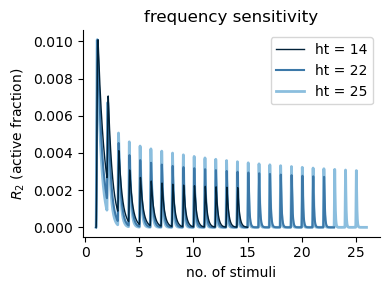

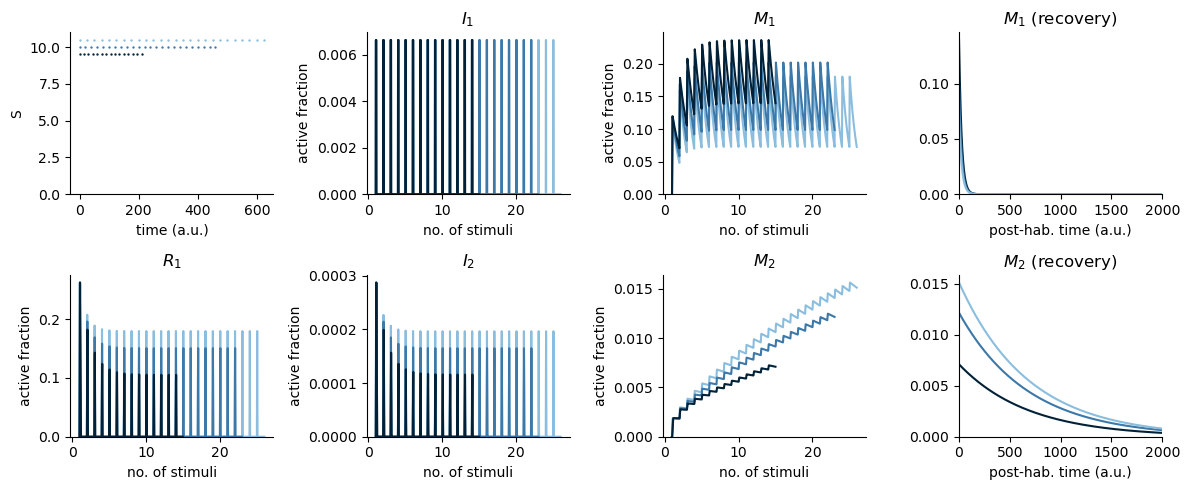

Intensity sensitivity
T 15 A 10 14 1548.81
T 15 A 20 32 2291.19
T 15 A 30 40 2600.69


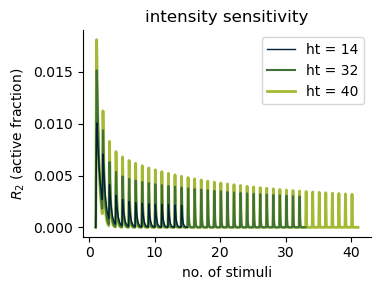

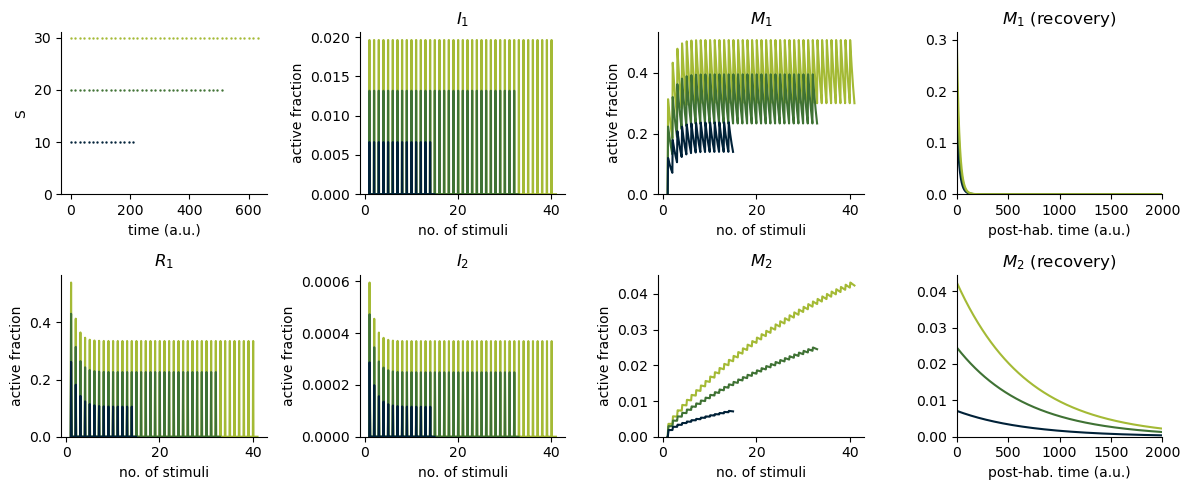

Potentiation
T 15 A 10


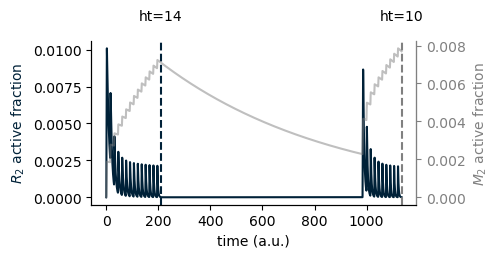

T 15 A 20


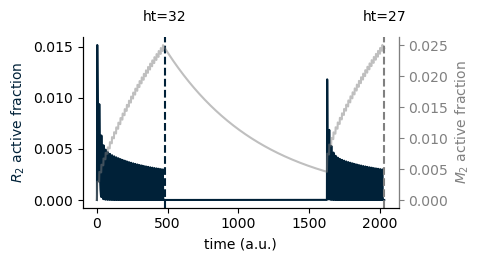

T 15 A 30


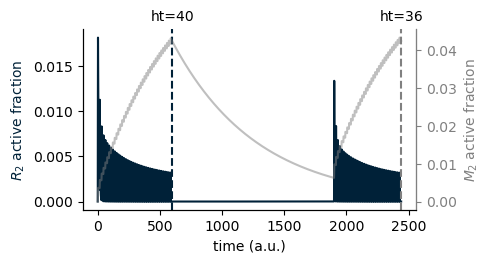

T 20 A 10


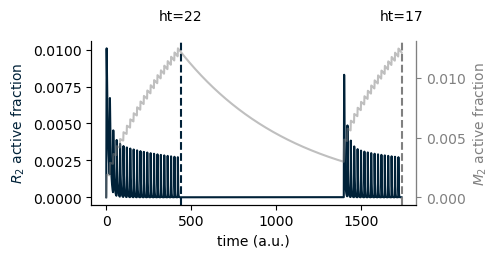

T 20 A 20


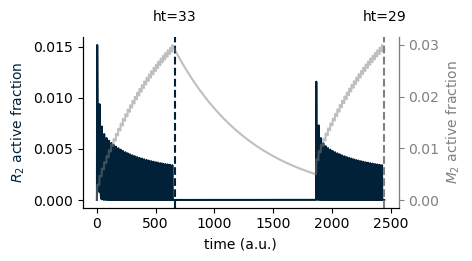

T 20 A 30


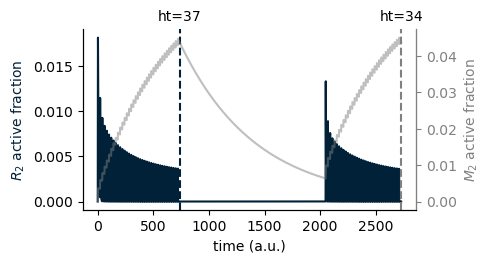

T 25 A 10


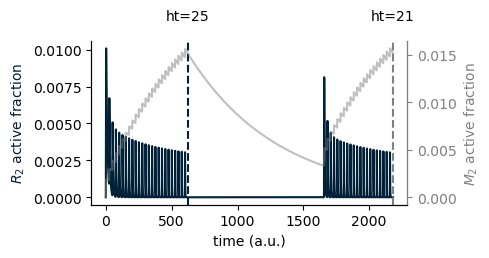

T 25 A 20


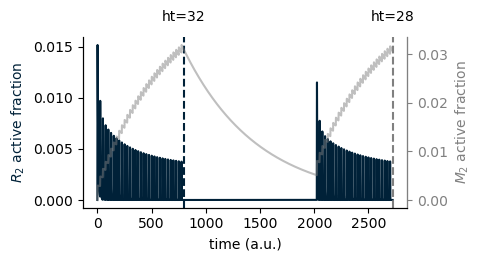

T 25 A 30


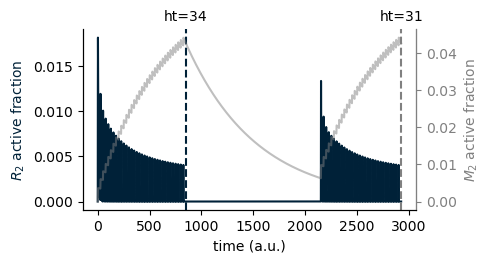

Subliminal
T 15 A 10


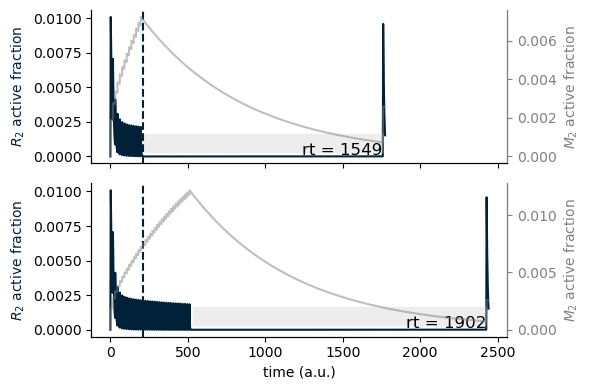

T 15 A 20


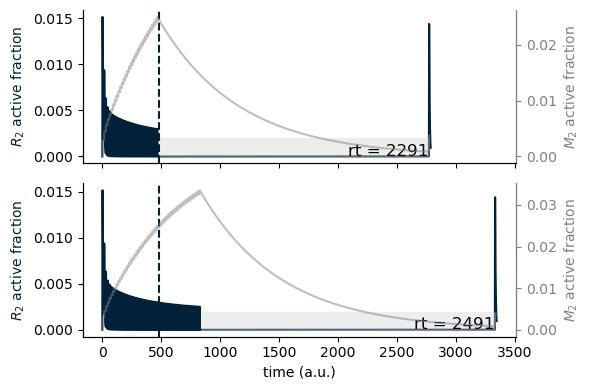

T 15 A 30


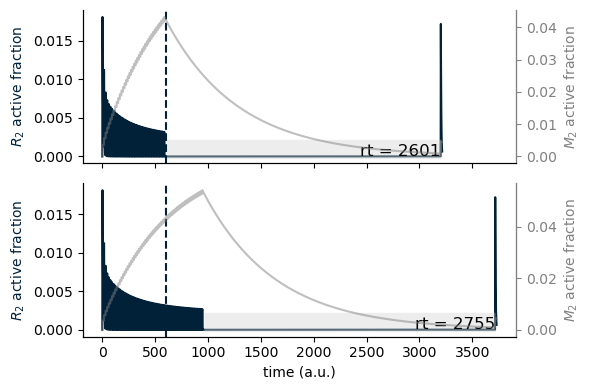

T 20 A 10


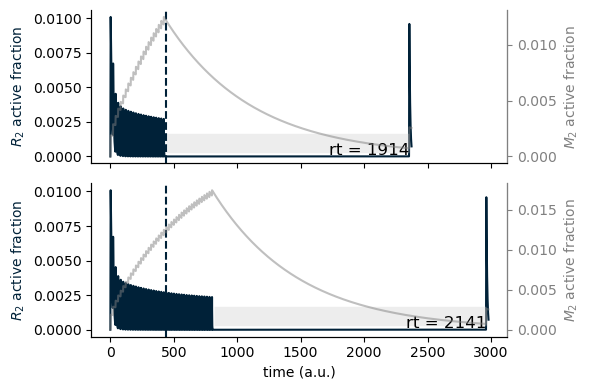

T 20 A 20


KeyboardInterrupt: 

In [3]:
#IFF
def f_iFF(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1, kIa2, kIi2, kMa2, kMi2, kRa2, kRi2, K_2): 
    # starting values 
    I1, M1, R1, I2, M2, R2 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = I1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)
    dI2 = R1*kIa2*(1.0-I2) - kIi2*I2
    dM2 = I2*kMa2*(1.0-M2) - kMi2*M2
    dR2 = I2*kRa2*(1.0-R2) - M2*kRi2*R2/(K_2+R2)

    return(dI1, dM1, dR1, dI2, dM2, dR2)
idxs={"I1":0, "M1":1, "R1":2, "I2":3, "M2":4, "R2":5}
# set parameters
 
p0=[0.023, 34.44, 17.7071, 0.038241, 57.9236, 1.39117, 0.000534, 
            0.016011, 14.3342,  4.33609, 0.001471, 26.1702, 45.9986, 0.79082] #only rates and ODE parameters
Ton= 1.1111111111111112
Amin=0

X0 = [0,0,0,0,0,0] 

steps_per_time = 100

mys = system.System(f_iFF,p0, X0,output_var_idx=-1,steps_per_time=steps_per_time,hmax=0)

Sfs=10
T_scan_set = [15, 20, 25]
Tis=15
A_scan_set=[10,20,30]

folder="../../habituation/2023_paper/figs/panels"
basename="cIFF"

print("Frequency sensitivity")
output = execute_freq_sens(mys,T_scan_set=T_scan_set,Amin=0, Amax=Sfs, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)

namesave="%s_freqs.pdf"%basename
savepath=os.path.join(folder,namesave)
plot_freq_or_is(*output,T_scan_set=T_scan_set, A_scan_set=[Sfs],varname="$R_2$",idx=-1,
                      kind="freqs",colors=colorsf,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=savepath)

namesave="%s_freqs_traj.pdf"%basename
savepath=os.path.join(folder,namesave)
plot_trajectories(*output,idxs=idxs, T_scan_set=T_scan_set, A_scan_set=[Sfs], 
                      kind="freqs",offsets=[0.95,1,1.05],colors=colorsf,steps_per_time=steps_per_time,
                  zorder=[3,2,1],xlimrec=2000,ylims=11,savepath=savepath)

print("Intensity sensitivity")
output = execute_int_sens(mys,A_scan_set=A_scan_set,Amin=0,T=Tis, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)


namesave="%s_ints.pdf"%basename
savepath=os.path.join(folder,namesave)
plot_freq_or_is(*output,T_scan_set=[Tis], A_scan_set=A_scan_set,varname="$R_2$",idx=-1,
                      kind="ints",colors=colorsi,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=savepath)

namesave="%s_ints_traj.pdf"%basename
savepath=os.path.join(folder,namesave)
plot_trajectories(*output,idxs=idxs, T_scan_set=[Tis], A_scan_set=A_scan_set, 
                      kind="ints",colors=colorsi,steps_per_time=steps_per_time,
                  zorder=[3,2,1],xlimrec=2000,ylims=None,savepath=savepath)


print("Potentiation")
for T in T_scan_set:
    for A in A_scan_set:
        print("T", T, "A", A)
        rtf=0.5
        namesave="%s_pot_%g_T=%g_A=%g.pdf"%(basename, rtf, T, A)
        savepath=os.path.join(folder,namesave)

        potentiation(f_iFF,p0,X0,varname_R="$R_2$", varname_M="$M_2$",idxR=-1,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,ht_threshold=0.01,recovery_threshold=0.95,
                         steps_per_time=steps_per_time,rt_fraction=rtf,savepath=savepath,color=colorsf[0])

print("Subliminal")
for T in T_scan_set:
    for A in A_scan_set:
        print("T", T, "A", A)

        namesave="%s_sub_T=%g_A=%g.pdf"%(basename, T, A)
        savepath=os.path.join(folder,namesave)

        subliminal(f_iFF,p0,X0,varname_R="$R_2$", varname_M="$M_2$",idxR=-1,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,
                   ht_threshold1=0.01,ht_threshold2=0.005,recovery_threshold=0.95,
                    steps_per_time=steps_per_time,savepath=savepath,color=colorsf[0])

# Concatenated NF

Frequency sensitivity


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A 15 T 5 12 6649.38
A 15 T 10 18 7312.45
A 15 T 15 21 7669.64


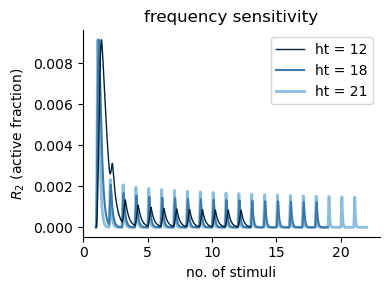

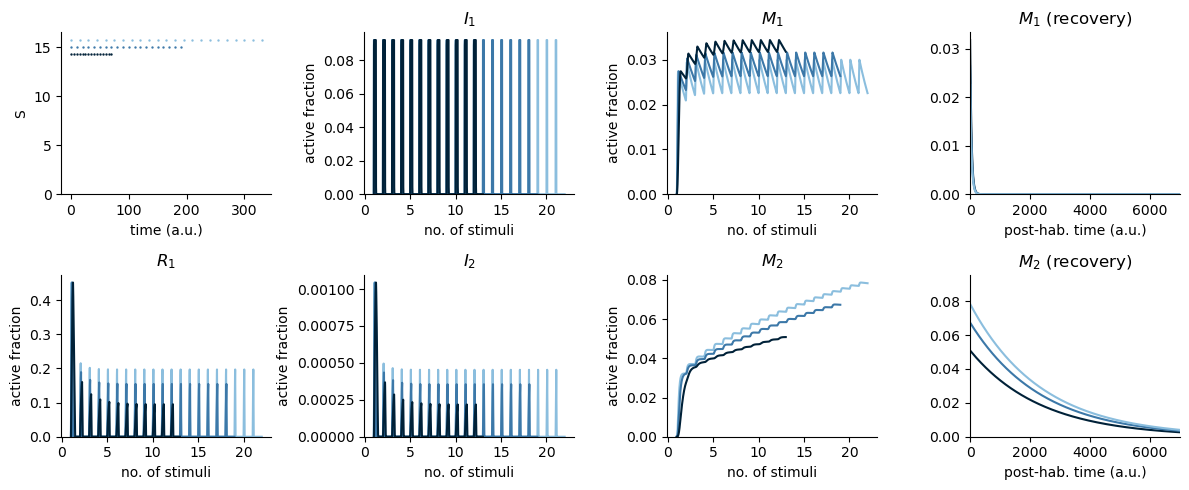

Recovery envelope


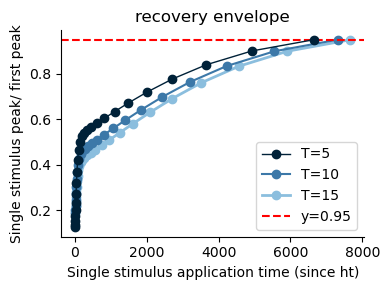

Potentiation
T 5 A 10
A 10 T 5 rt 6342.77 time at which new train applied is 1585


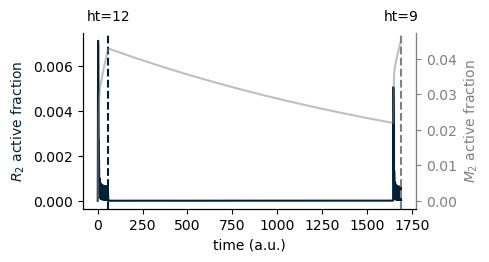

T 5 A 15


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A 15 T 5 rt 6649.38 time at which new train applied is 1662


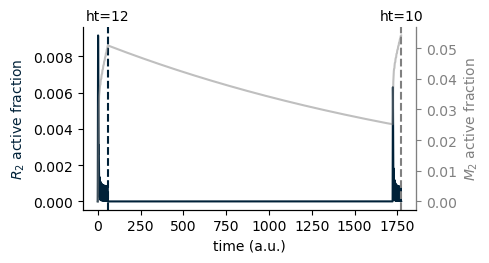

T 5 A 20
A 20 T 5 rt 6908.95 time at which new train applied is 1727


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


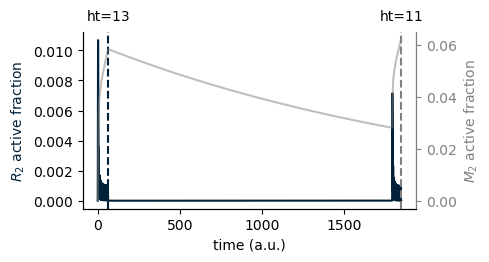

T 10 A 10
A 10 T 10 rt 6861.51 time at which new train applied is 1715


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


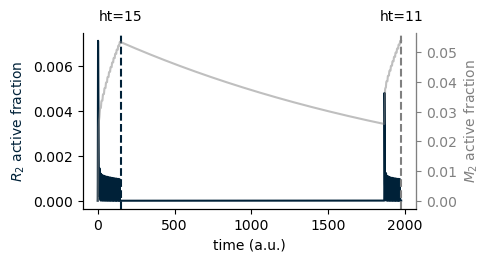

T 10 A 15
A 15 T 10 rt 7312.45 time at which new train applied is 1828


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


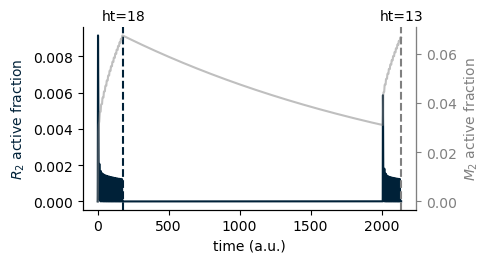

T 10 A 20


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A 20 T 10 rt 1659.95 time at which new train applied is 414


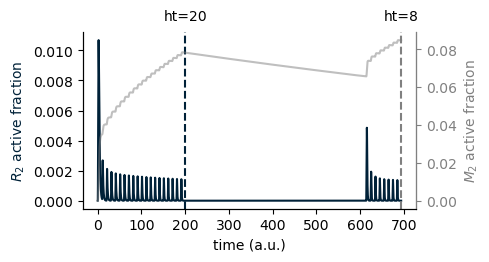

T 15 A 10
A 10 T 15 rt 7246.68 time at which new train applied is 1811


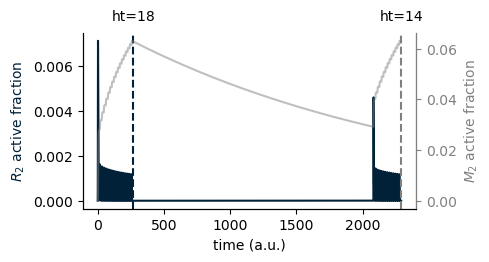

T 15 A 15
A 15 T 15 rt 7669.64 time at which new train applied is 1917


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


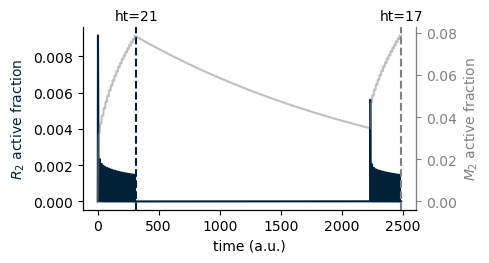

T 15 A 20


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A 20 T 15 rt 1699.88 time at which new train applied is 424


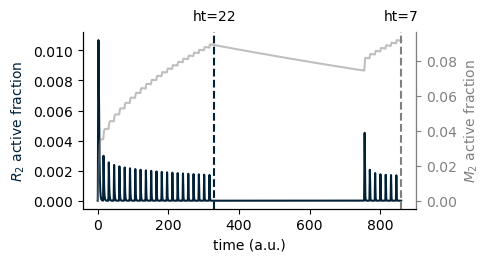

Subliminal
T 5 A 10


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


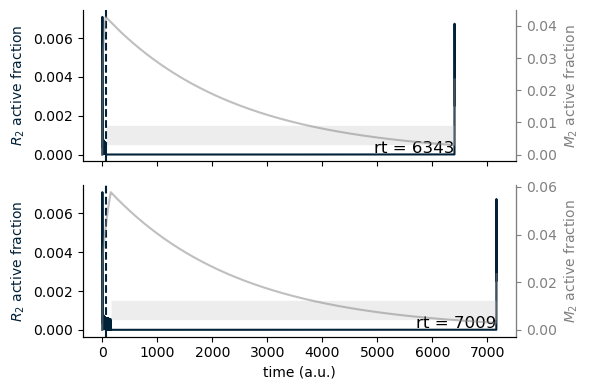

T 5 A 15


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


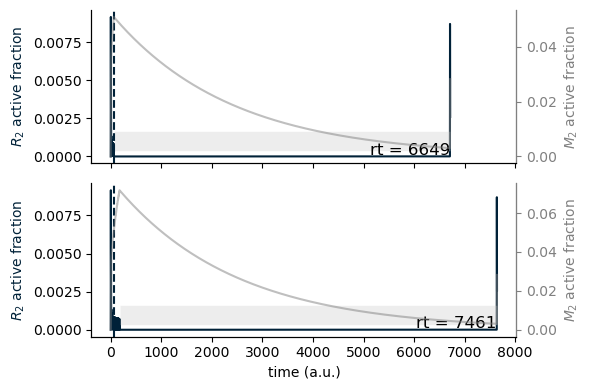

T 5 A 20


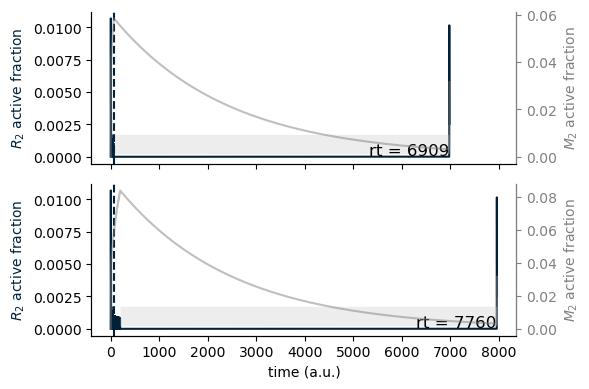

T 10 A 10


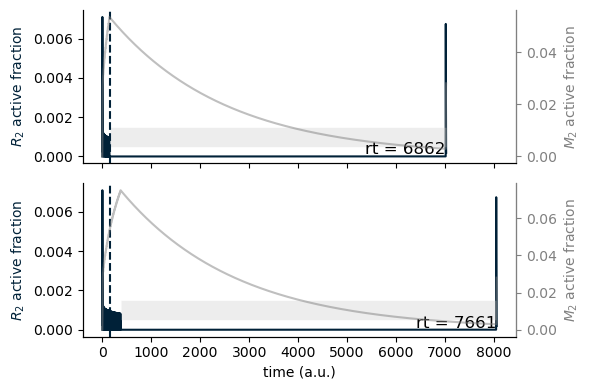

T 10 A 15


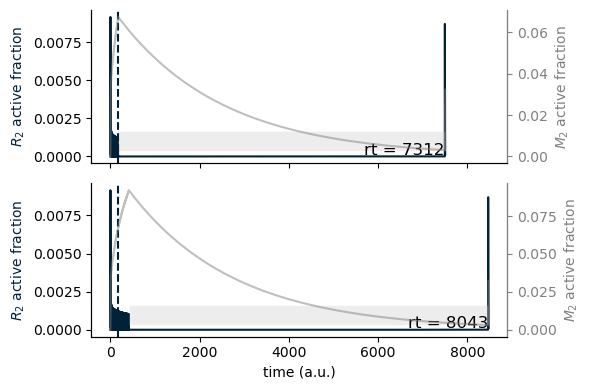

T 10 A 20


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


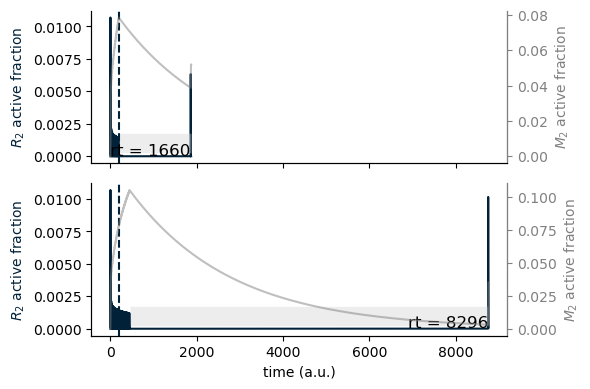

T 15 A 10


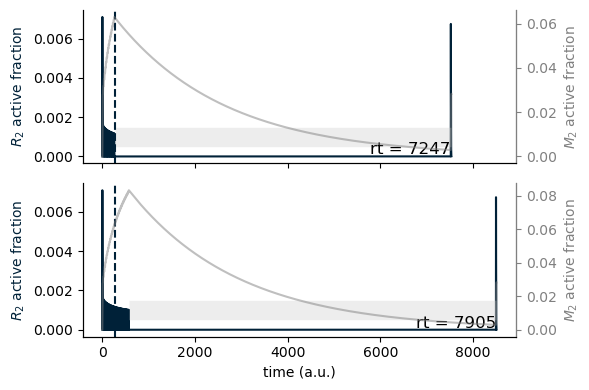

T 15 A 15


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


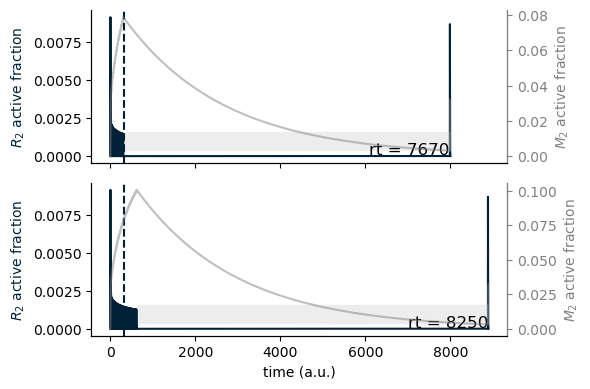

T 15 A 20


c:\Users\Maria\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


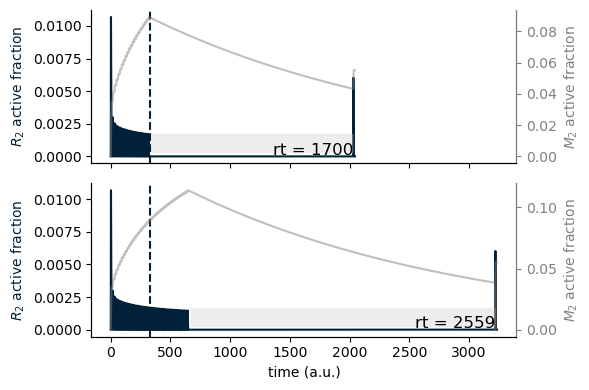

In [10]:
def f_cNF(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1, kIa2, kIi2, kMa2, kMi2, kRa2, kRi2, K_2): 
    # starting values 
    I1, M1, R1, I2, M2, R2 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)
    dM1 = R1*kMa1*(1.0-M1) - kMi1*M1
    dI2 = R1*kIa2*(1.0-I2) - kIi2*I2
    dR2 = I2*kRa2*(1.0-R2) - M2*kRi2*R2/(K_2+R2)
    dM2 = R2*kMa2*(1.0-M2) - kMi2*M2

    return(dI1, dM1, dR1, dI2, dM2, dR2)
# set parameters
 
idxs={"I1":0, "M1":1, "R1":2, "I2":3, "M2":4, "R2":5}


p0 = [0.230081, 33.9724, 0.0490086, 0.0211482, 7.74146, 18.194, 0.000690869, 
            0.0373467, 15.9387, 1.0256, 0.000423467, 7.50814, 22.3856, 1.14693]

Ton= 1.1111111111111112
Amin=0

T_scan_set=[5,10,15]
A_scan_set = [10, 15, 20]
Sfs=15
Tis=10


X0 = [0,0,0,0,0,0] 

steps_per_time = 100


mys = system.System(f_cNF,p0, X0,output_var_idx=-1,steps_per_time=steps_per_time,hmax=0)


#folder="../../habituation/2023_paper/figs/panels"
folder=".."
basename="cNF"

if True:
    mys = system.System(f_cNF,p0, X0,output_var_idx=-1,steps_per_time=steps_per_time,hmax=0)
    print("Frequency sensitivity")
    output = execute_freq_sens(mys,T_scan_set=T_scan_set,Amin=0, Amax=Sfs, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)

    namesave="%s_freqs.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_freq_or_is(*output,T_scan_set=T_scan_set, A_scan_set=[Sfs],varname="$R_2$",idx=-1,
                          kind="freqs",colors=colorsf,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=savepath)

    namesave="%s_freqs_traj.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_trajectories(*output,idxs=idxs, T_scan_set=T_scan_set, A_scan_set=[Sfs], 
                          kind="freqs",offsets=[0.95,1,1.05],colors=colorsf,steps_per_time=steps_per_time,
                      zorder=[3,2,1],xlimrec=7000,ylims=1.1*Sfs,savepath=savepath)
    #adjust xlimrec to look good
    
    mys = system.System(f_cNF,p0, X0,output_var_idx=-1,steps_per_time=steps_per_time,hmax=0.01)
    print("Intensity sensitivity")
    output = execute_int_sens(mys,A_scan_set=A_scan_set,Amin=0,T=Tis, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)


    namesave="%s_ints.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_freq_or_is(*output,T_scan_set=[Tis], A_scan_set=A_scan_set,varname="$R_2$",idx=-1,
                          kind="ints",colors=colorsi,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=savepath)

    namesave="%s_ints_traj.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_trajectories(*output,idxs=idxs, T_scan_set=[Tis], A_scan_set=A_scan_set, 
                          kind="ints",colors=colorsi,steps_per_time=steps_per_time,
                      zorder=[3,2,1],xlimrec=7000,ylims=None,savepath=savepath)
    
    mys = system.System(f_cNF,p0, X0,output_var_idx=-1,steps_per_time=steps_per_time,hmax=0.01)
    print("Recovery envelope")
    tperturblist_Ts, peak_norm_Ts = execute_recovery_envelope(mys, height_peaks=0.001, T_scan_set=T_scan_set,Amin=0, 
                                                              Amax=Sfs, Ton=Ton, ht_threshold=0.01, recovery_threshold=0.95)

    plot_recovery_envelope(tperturblist_Ts, peak_norm_Ts, T_scan_set=T_scan_set, A_scan_set=[Sfs], 
                            colors=colorsf,steps_per_time=steps_per_time, zorder=[3,2,1],savepath=savepath)

    mys = system.System(f_cNF,p0, X0,output_var_idx=-1,steps_per_time=steps_per_time,hmax=0)
    print("Potentiation")
    for T in T_scan_set:
        for A in A_scan_set:
            print("T", T, "A", A)
            rtf=0.25
            namesave="%s_pot_%g_T=%g_A=%g.pdf"%(basename, rtf, T, A)
            savepath=os.path.join(folder,namesave)
            
            potentiation(f_cNF,p0,X0,varname_R="$R_2$", varname_M="$M_2$",idxR=-1,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,ht_threshold=0.01,recovery_threshold=0.95,
                            steps_per_time=steps_per_time,rt_fraction=rtf,savepath=savepath,color=colorsf[0])

    print("Subliminal")
    for T in T_scan_set:
        for A in A_scan_set:
            print("T", T, "A", A)
            namesave="%s_sub_T=%g_A=%g.pdf"%(basename, T, A)
            savepath=os.path.join(folder,namesave)

            subliminal(f_cNF,p0,X0,varname_R="$R_2$", varname_M="$M_2$",idxR=-1,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,
                    ht_threshold1=0.01,ht_threshold2=0.005,recovery_threshold=0.95,
                        steps_per_time=steps_per_time,savepath=savepath,color=colorsf[0])

# Receptor + IFF

Frequency sensitivity
A 5 T 10 24 3340.2
A 5 T 15 28 3685.62
A 5 T 25 30 3993.16


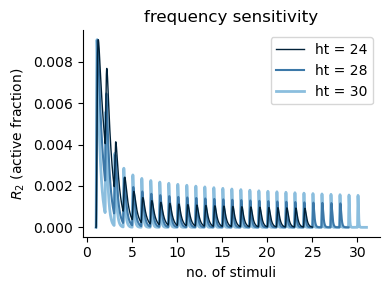

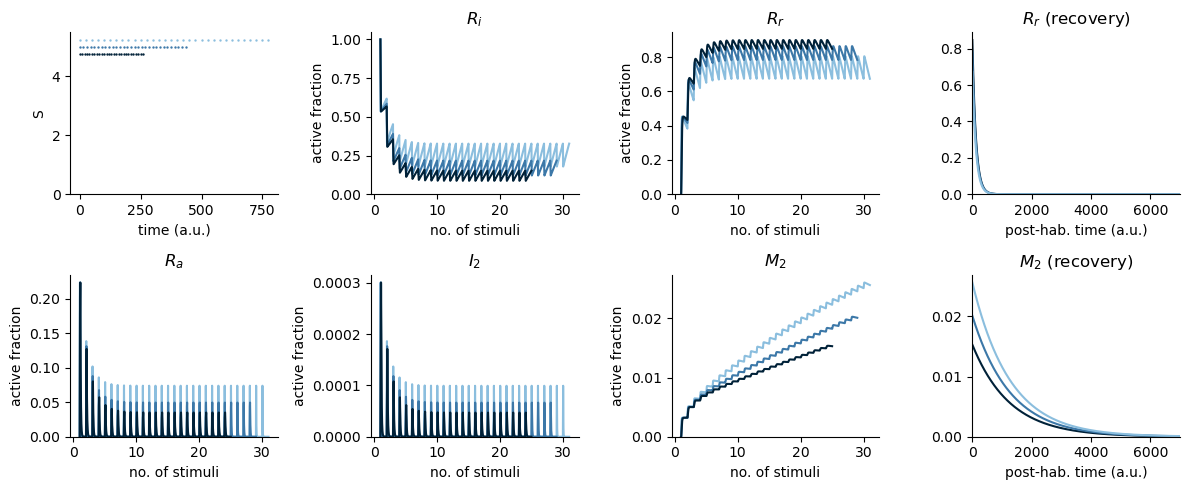

Intensity sensitivity
T 25 A 2 27 3783.7
T 25 A 5 30 3993.16
T 25 A 15 32 3982.92


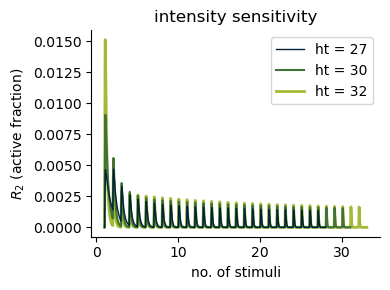

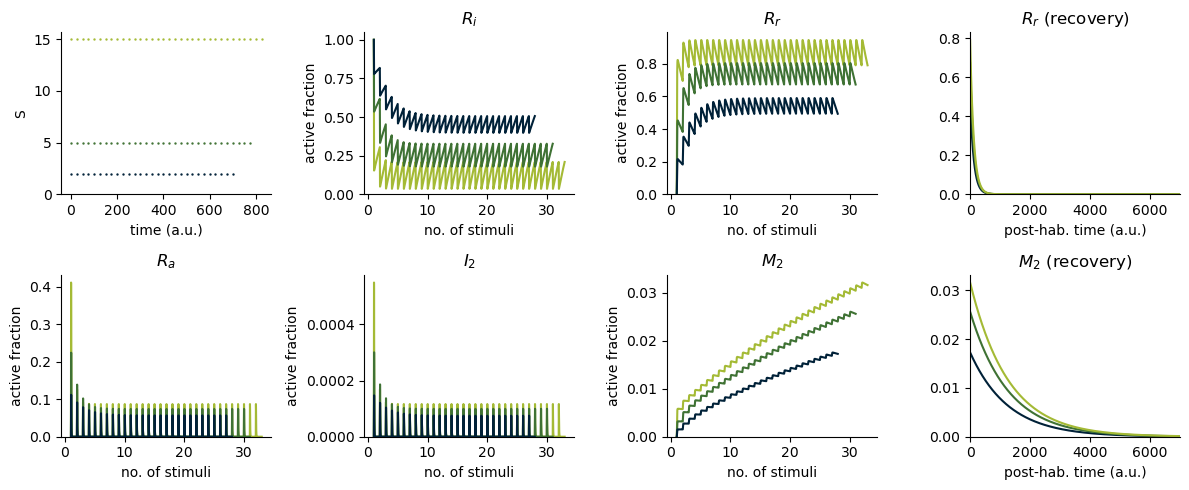

Potentiation
T 10 A 2


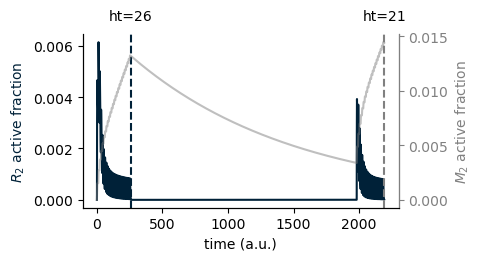

T 10 A 5


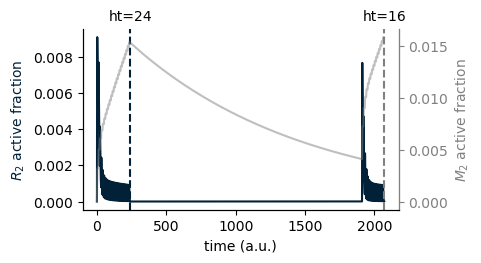

T 10 A 15


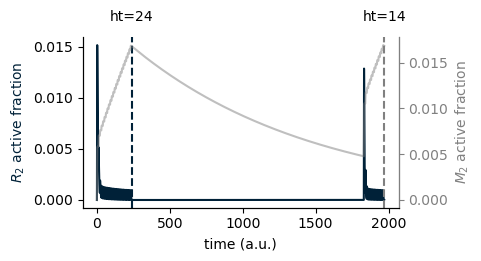

T 15 A 2


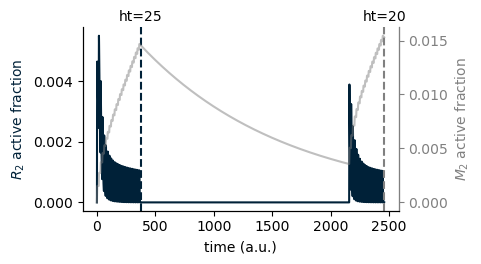

T 15 A 5


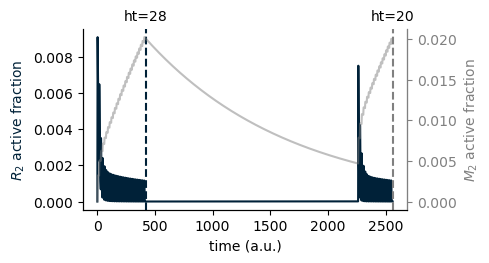

T 15 A 15


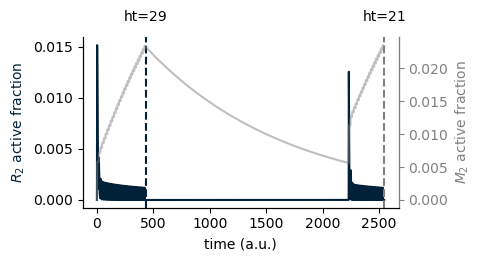

T 25 A 2


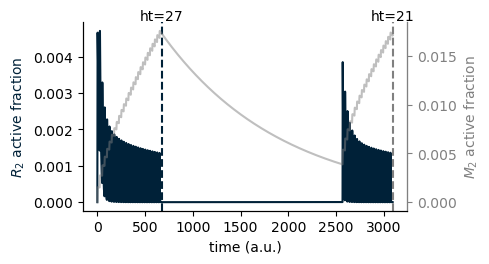

T 25 A 5


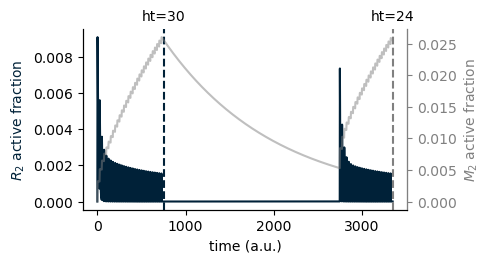

T 25 A 15


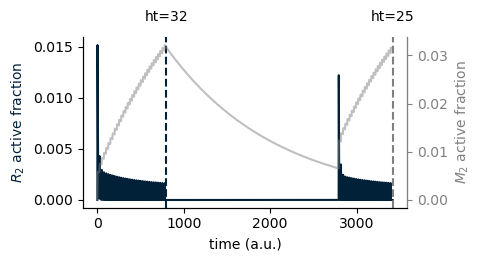

Subliminal
T 10 A 2


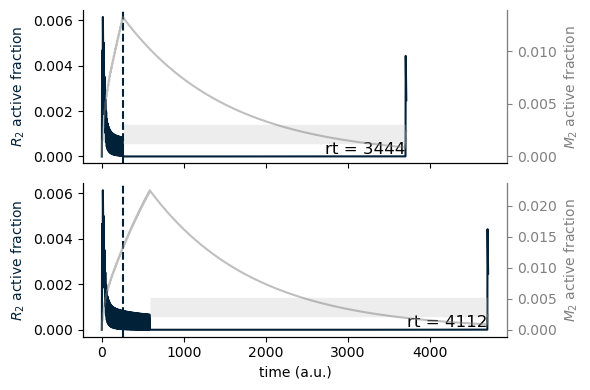

T 10 A 5


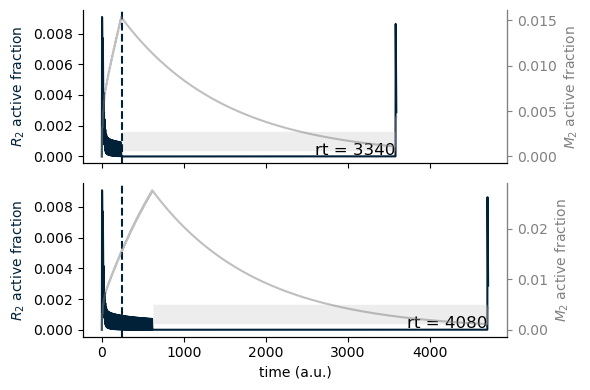

T 10 A 15


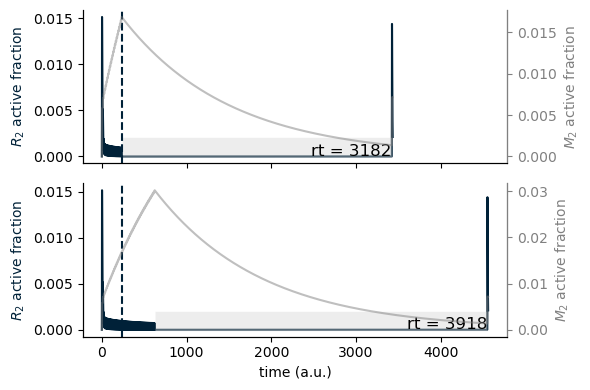

T 15 A 2


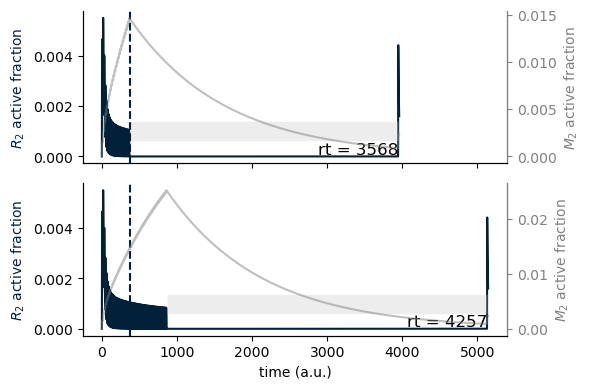

T 15 A 5


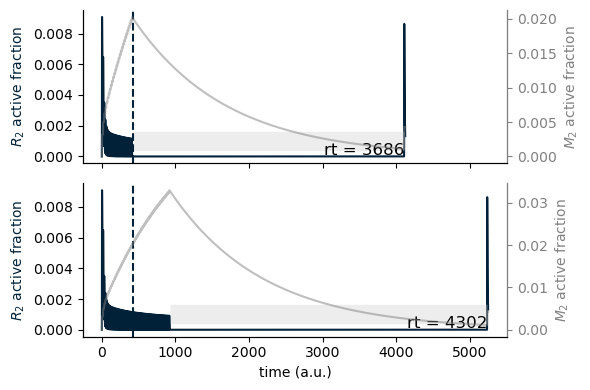

T 15 A 15


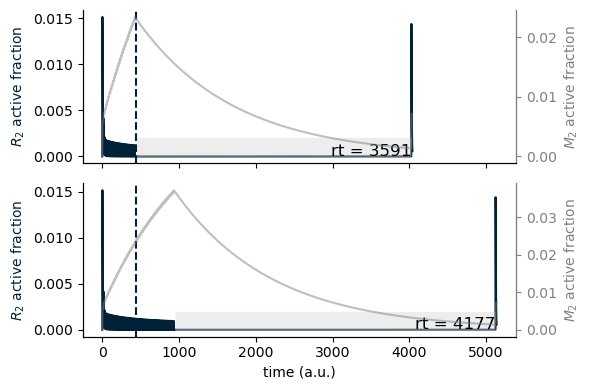

T 25 A 2


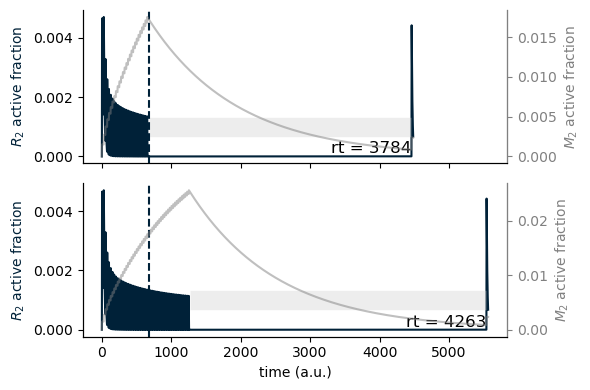

T 25 A 5


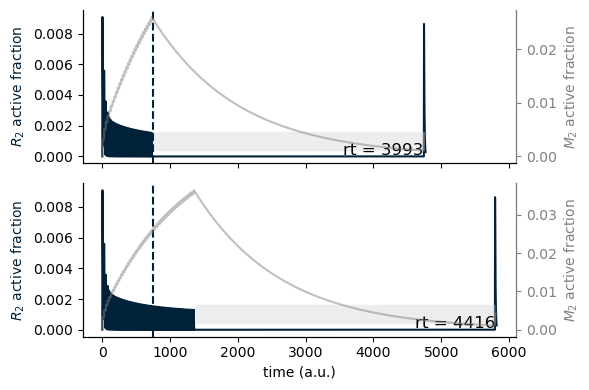

T 25 A 15


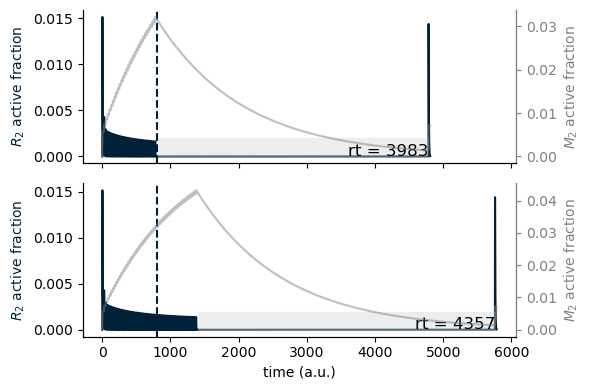

In [12]:
def f_R_IFF(X, t, S, k1, k2, k3, kIa2, kIi2, kMa2, kMi2, kRa2, kRi2):
    # starting values
    Ri, Rr, Ra, I2, M2, R2 = X

    dRi  = k3*Rr - k1*S*Ri
    dRa = S*k1*Ri - k2*Ra
    dRr = k2*Ra - k3*Rr 
    dI2 = Ra*kIa2*(1.0-I2) - kIi2*I2
    dM2 = I2*kMa2*(1.0-M2) - kMi2*M2
    dR2 = I2*kRa2*(1.0-R2) - M2*kRi2*R2 

    return(dRi, dRr, dRa, dI2, dM2, dR2)
# set parameters
 
idxs={"Ri":0, "Rr":1, "Ra":2, "I2":3, "M2":4, "R2":5}
#["I1", "M1", "R1", "I2", "M2"]
variables_toplot=["Ri","Rr","Ra","I2","M2"]
Ms_toplot=["Rr","M2"]

p0 = [0.125459000, 1.497200000, 0.008299870 ,0.015193000, 11.204000000, 7.645580000 ,0.000790337, 25.958200000 ,36.517700000]

Ton=1.0
Amin=0
            

T_scan_set=[10,15,25]
A_scan_set = [2, 5, 15]
Sfs=5
Tis=25


X0 = [1,0,0,0,0,0] 

steps_per_time = 100


mys = system.System(f_R_IFF,p0, X0,output_var_idx=-1,steps_per_time=steps_per_time,hmax=0)


folder="../../habituation/2023_paper/figs/panels"
basename="R_IFF"

if True:
    print("Frequency sensitivity")
    output = execute_freq_sens(mys,T_scan_set=T_scan_set,Amin=0, Amax=Sfs, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)

    namesave="%s_freqs.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_freq_or_is(*output,T_scan_set=T_scan_set, A_scan_set=[Sfs],varname="$R_2$",idx=-1,
                          kind="freqs",colors=colorsf,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=savepath)

    namesave="%s_freqs_traj.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_trajectories(*output,idxs=idxs, T_scan_set=T_scan_set, A_scan_set=[Sfs], variables_toplot=variables_toplot,
                          Ms_toplot=Ms_toplot,kind="freqs",offsets=[0.95,1,1.05],colors=colorsf,steps_per_time=steps_per_time,
                      zorder=[3,2,1],xlimrec=7000,ylims=1.1*Sfs,savepath=savepath)
    #adjust xlimrec to look good

    print("Intensity sensitivity")
    output = execute_int_sens(mys,A_scan_set=A_scan_set,Amin=0,T=Tis, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)


    namesave="%s_ints.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_freq_or_is(*output,T_scan_set=[Tis], A_scan_set=A_scan_set,varname="$R_2$",idx=-1,
                          kind="ints",colors=colorsi,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=savepath)

    namesave="%s_ints_traj.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_trajectories(*output,idxs=idxs, T_scan_set=[Tis], A_scan_set=A_scan_set,variables_toplot=variables_toplot,
                          Ms_toplot=Ms_toplot,kind="ints",colors=colorsi,steps_per_time=steps_per_time,
                      zorder=[3,2,1],xlimrec=7000,ylims=None,savepath=savepath)

print("Potentiation")
for T in T_scan_set:
    for A in A_scan_set:
        print("T", T, "A", A)
        rtf=0.5
        namesave="%s_pot_%g_T=%g_A=%g.pdf"%(basename, rtf, T, A)
        savepath=os.path.join(folder,namesave)
        
        potentiation(f_R_IFF,p0,X0,varname_R="$R_2$", varname_M="$M_2$",idxR=-1,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,ht_threshold=0.01,recovery_threshold=0.95,
                         steps_per_time=steps_per_time,rt_fraction=rtf,savepath=savepath,color=colorsf[0])

print("Subliminal")
for T in T_scan_set:
    for A in A_scan_set:
        print("T", T, "A", A)
        namesave="%s_sub_T=%g_A=%g.pdf"%(basename, T, A)
        savepath=os.path.join(folder,namesave)

        subliminal(f_R_IFF,p0,X0,varname_R="$R_2$", varname_M="$M_2$",idxR=-1,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,
                   ht_threshold1=0.01,ht_threshold2=0.005,recovery_threshold=0.95,
                    steps_per_time=steps_per_time,savepath=savepath,color=colorsf[0])

A 2 T 10 26 3443.7
A 2 T 15 25 3567.84
A 2 T 25 27 3783.7


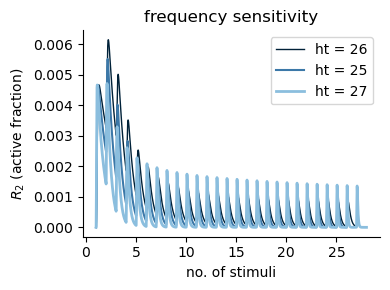

In [15]:
#A=2, sensitisation happens first. 
#Plot the freq sens - it does not hold but to see the sensitisation effect. Note that between lowest and highest T it does increase
output = execute_freq_sens(mys,T_scan_set=T_scan_set,Amin=0, Amax=2, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)

namesave="%s_freqs.pdf"%basename
savepath=os.path.join(folder,namesave)
plot_freq_or_is(*output,T_scan_set=T_scan_set, A_scan_set=[Sfs],varname="$R_2$",idx=-1,
                      kind="freqs",colors=colorsf,steps_per_time=steps_per_time,zorder=[1,2,3],savepath=savepath)


# Receptor-feedback

Frequency sensitivity
A 10 T 5 7 1271.8
A 10 T 10 9 1911.26
A 10 T 15 10 2153.34


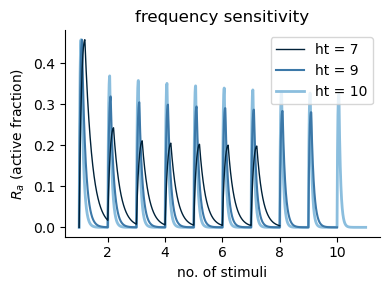

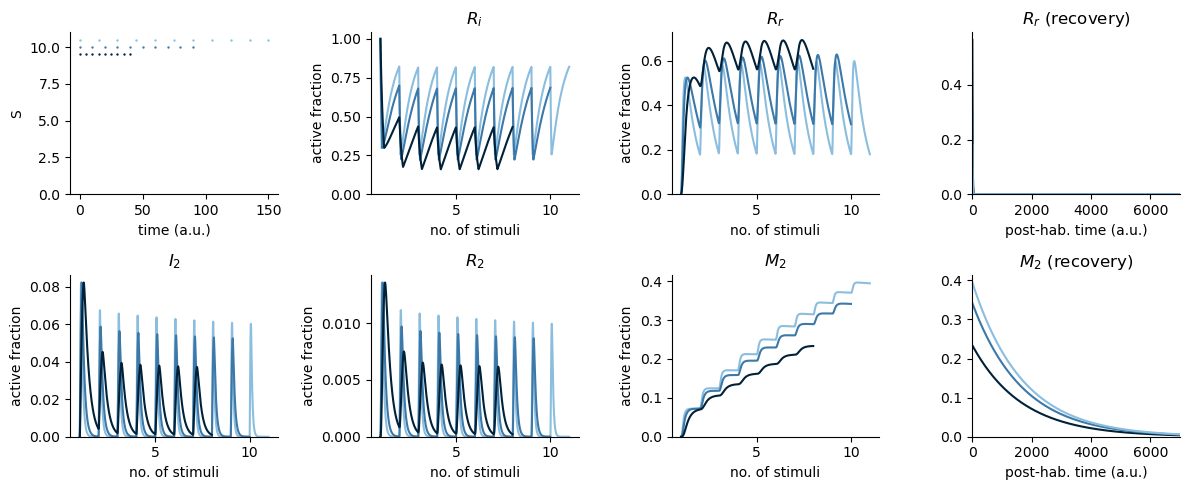

Intensity sensitivity
T 10 A 3 5 106.52
T 10 A 5 7 1074.64
T 10 A 10 9 1911.26


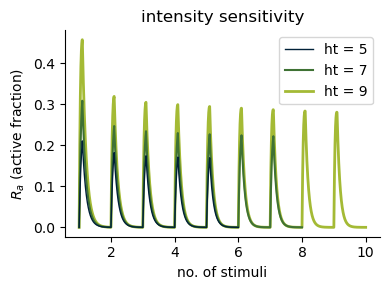

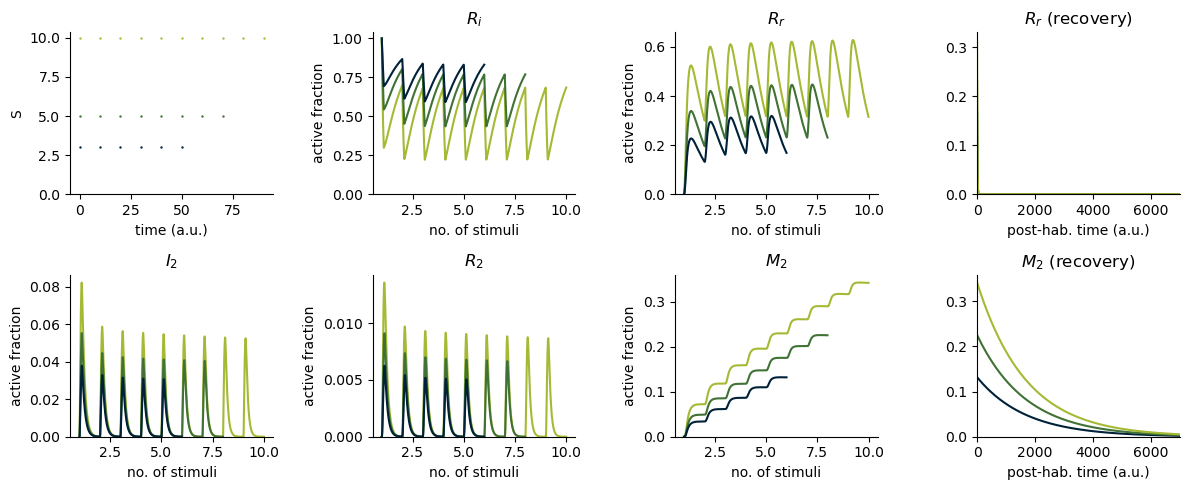

Potentiation
T 5 A 3
A 3 T 5 rt 156.17 time at which new train applied is 31


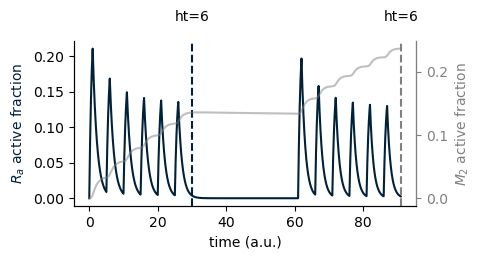

same but plotting Rr as memory
A 3 T 5 rt 156.17 time at which new train applied is 31


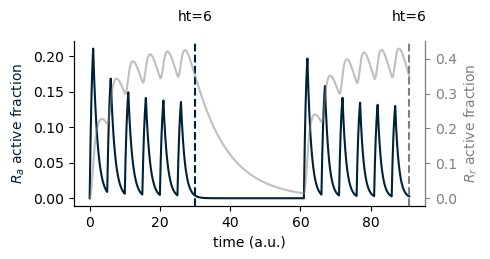

T 5 A 5
A 5 T 5 rt 613.7 time at which new train applied is 122


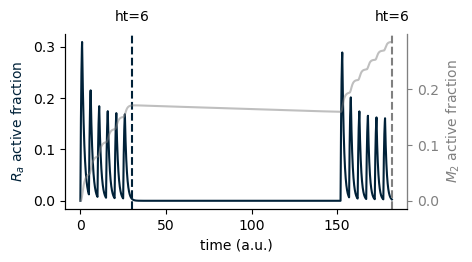

same but plotting Rr as memory
A 5 T 5 rt 613.7 time at which new train applied is 122


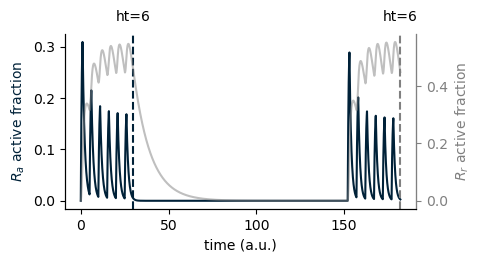

T 5 A 10
A 10 T 5 rt 1271.8 time at which new train applied is 254


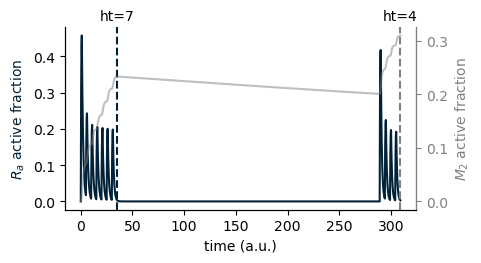

same but plotting Rr as memory
A 10 T 5 rt 1271.8 time at which new train applied is 254


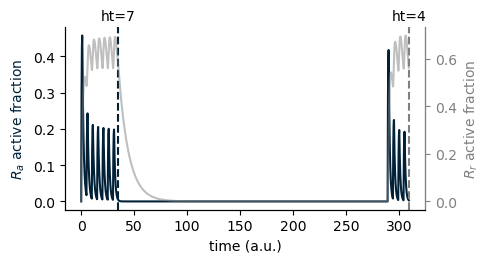

T 10 A 3
A 3 T 10 rt 106.52 time at which new train applied is 21


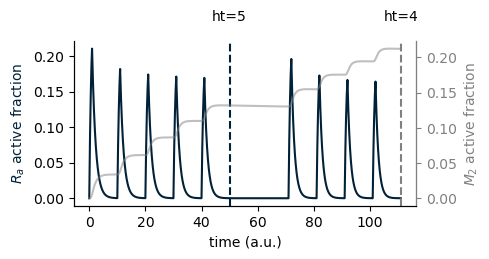

same but plotting Rr as memory
A 3 T 10 rt 106.52 time at which new train applied is 21


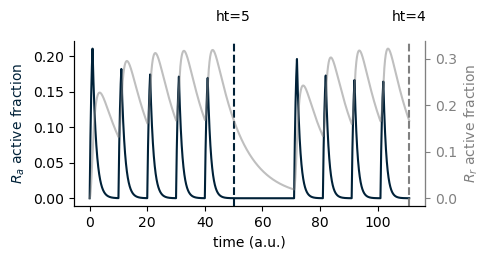

T 10 A 5
A 5 T 10 rt 1074.64 time at which new train applied is 214


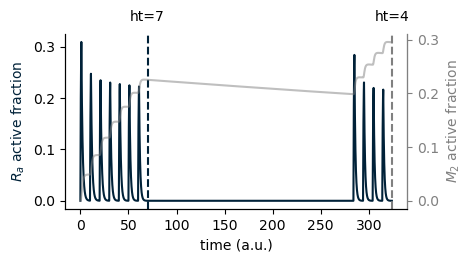

same but plotting Rr as memory
A 5 T 10 rt 1074.64 time at which new train applied is 214


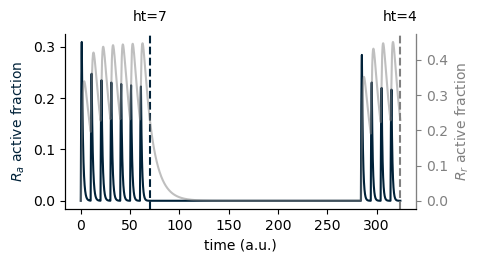

T 10 A 10
A 10 T 10 rt 1911.26 time at which new train applied is 382


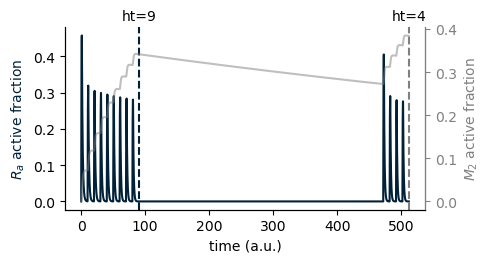

same but plotting Rr as memory
A 10 T 10 rt 1911.26 time at which new train applied is 382


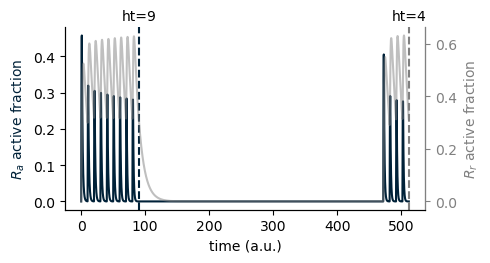

T 15 A 3
A 3 T 15 rt 177.09 time at which new train applied is 35


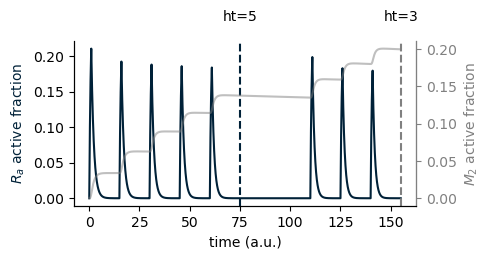

same but plotting Rr as memory
A 3 T 15 rt 177.09 time at which new train applied is 35


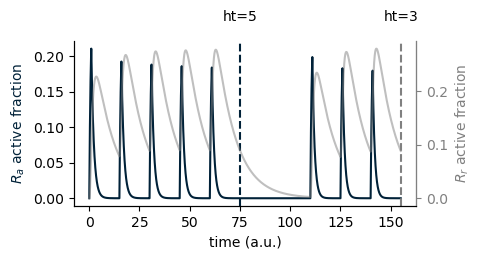

T 15 A 5
A 5 T 15 rt 1338.87 time at which new train applied is 267


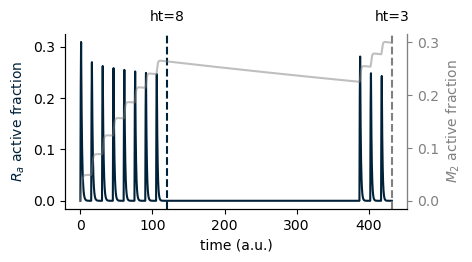

same but plotting Rr as memory
A 5 T 15 rt 1338.87 time at which new train applied is 267


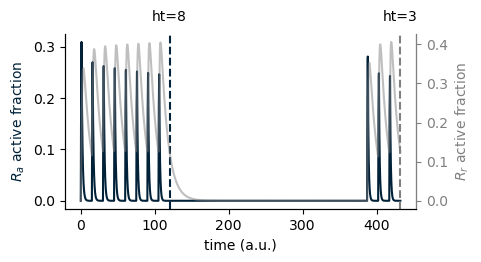

T 15 A 10
A 10 T 15 rt 2153.34 time at which new train applied is 430


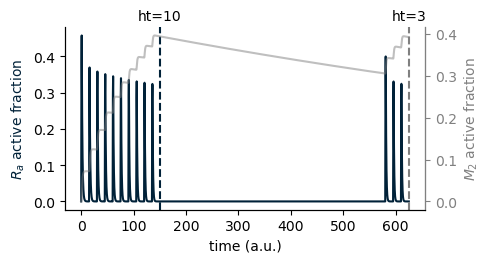

same but plotting Rr as memory
A 10 T 15 rt 2153.34 time at which new train applied is 430


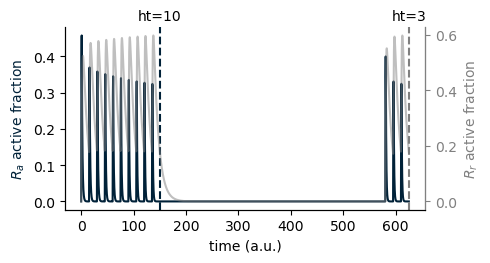

Subliminal
T 5 A 3


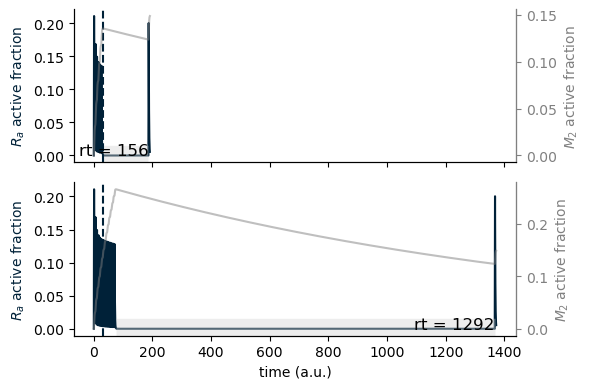

same but plotting Rr as memory


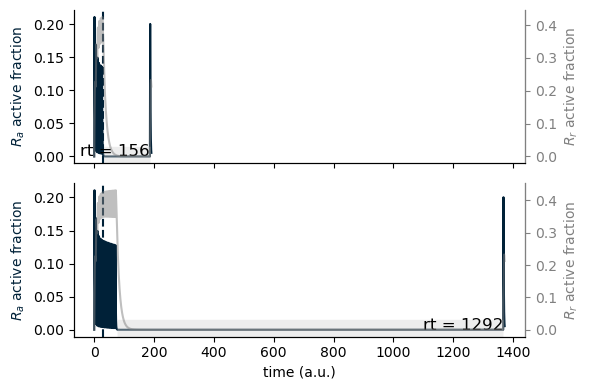

T 5 A 5


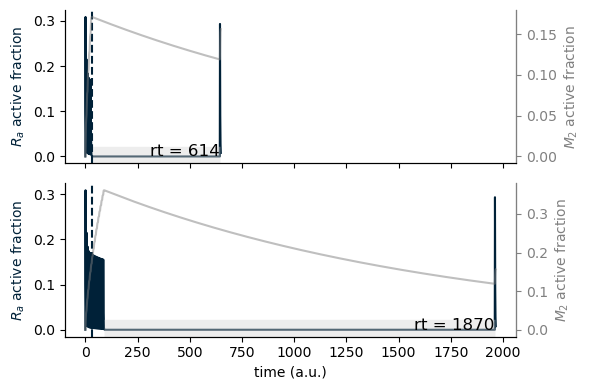

same but plotting Rr as memory


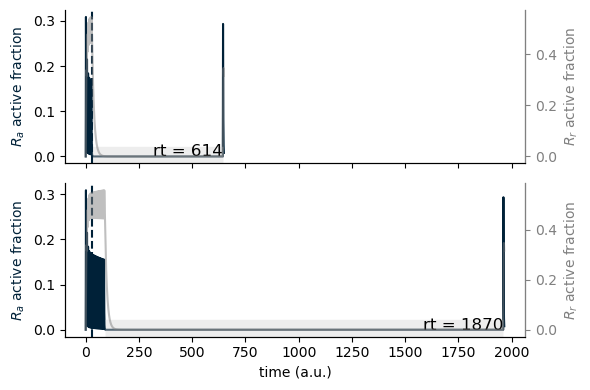

T 5 A 10


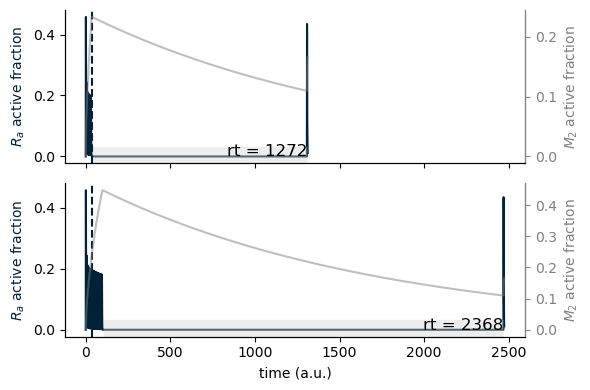

same but plotting Rr as memory


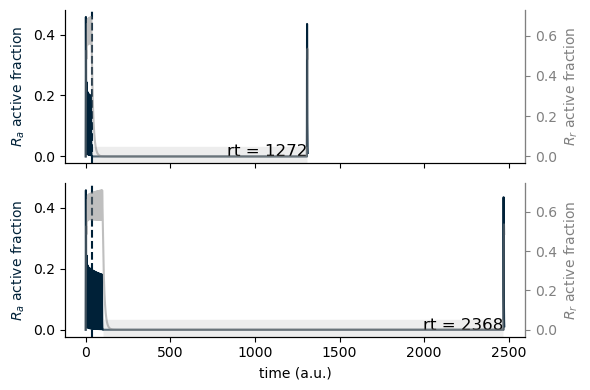

T 10 A 3


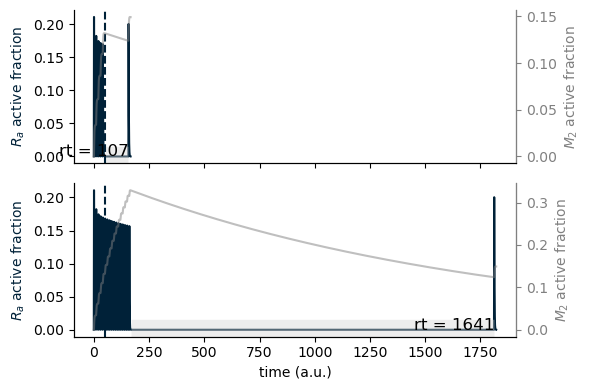

same but plotting Rr as memory


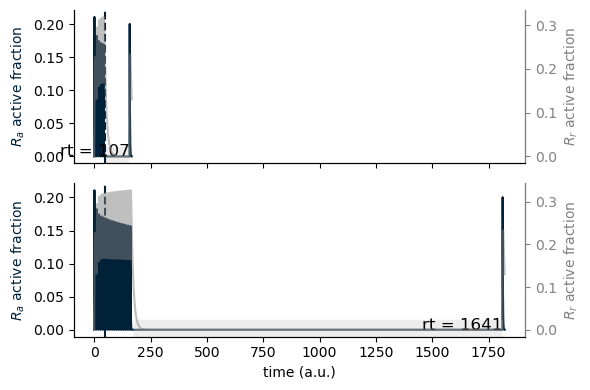

T 10 A 5


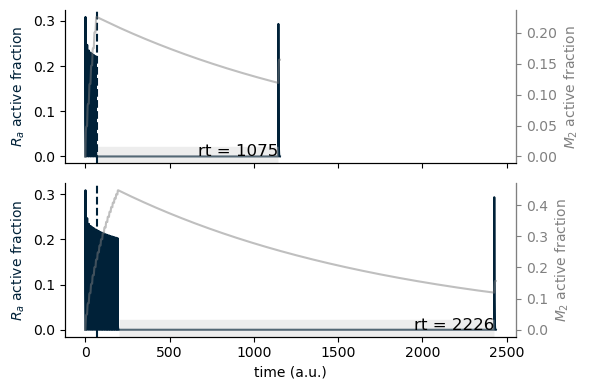

same but plotting Rr as memory


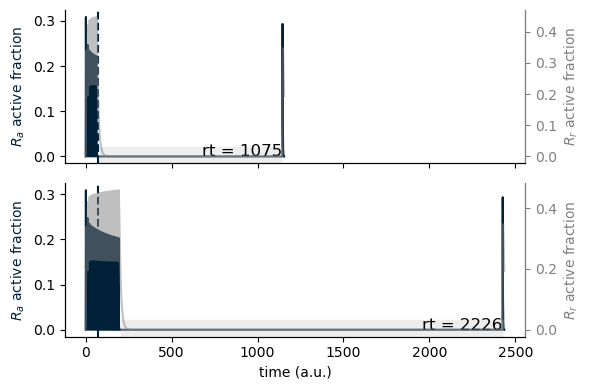

T 10 A 10


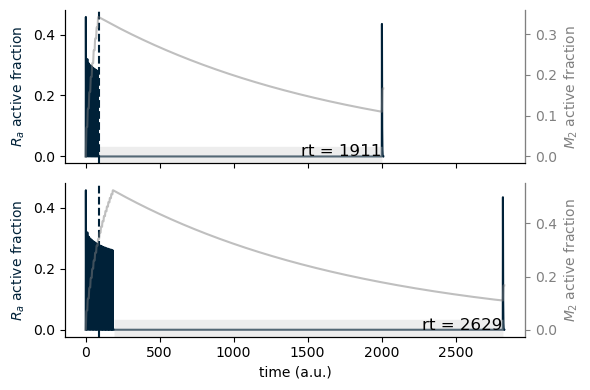

same but plotting Rr as memory


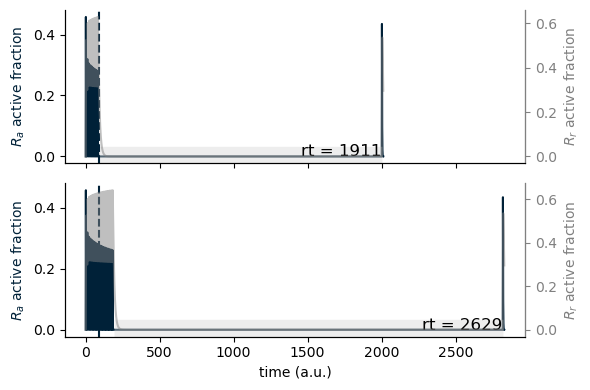

T 15 A 3


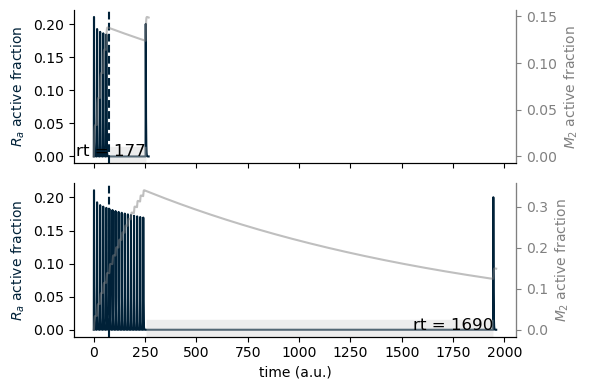

same but plotting Rr as memory


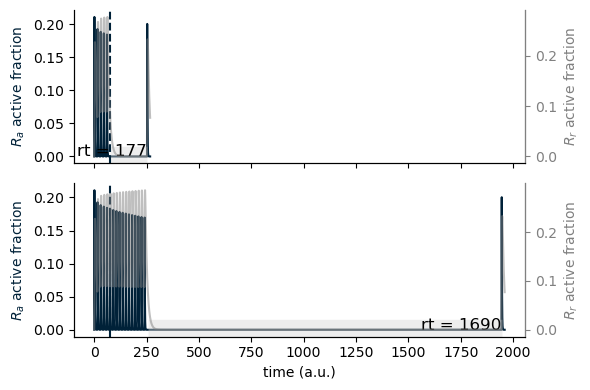

T 15 A 5


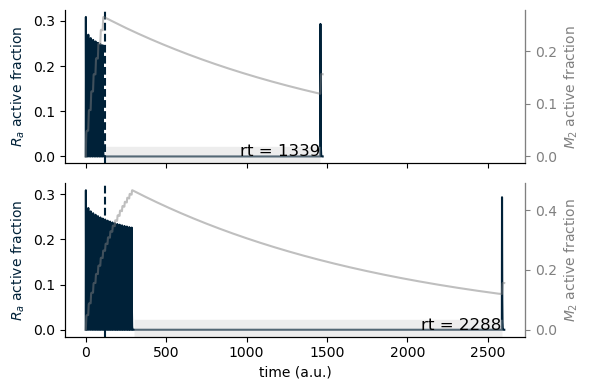

same but plotting Rr as memory


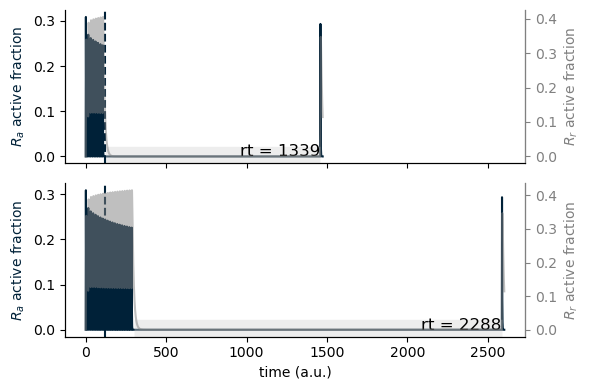

T 15 A 10


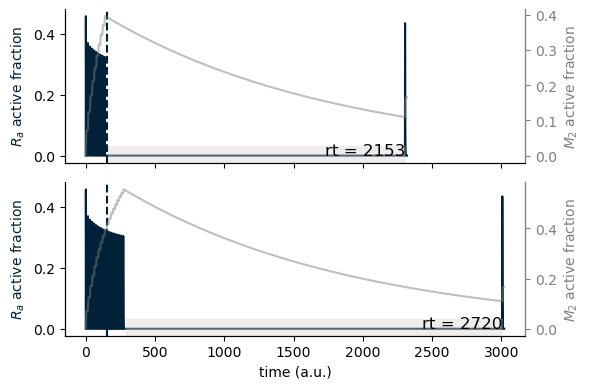

same but plotting Rr as memory


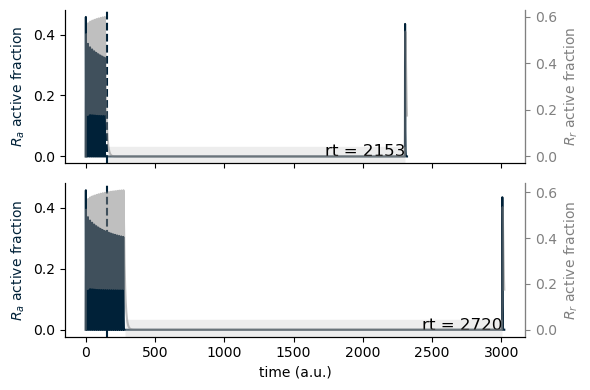

In [6]:
#with Ra as output node
def f_R_NF(X, t, S, k1, k2, k3, kMa, kIa2, kIi2, kRa2, kRi2, kMa2, kMi2):
    # starting values
    Ri, Rr, Ra, I2, M2, R2 = X

    dRi  = k3*Rr - k1*S*Ri
    dRr = k2*Ra + kMa*M2*Ra - k3*Rr 
    dRa = S*k1*Ri - k2*Ra - kMa*M2*Ra
    dI2 = kIa2*Ra*(1-I2) - kIi2*I2
    dR2 = kRa2*I2*(1-R2) - kRi2*R2
    dM2 = kMa2*R2*(1-M2) - kMi2*M2
    
    return(dRi, dRr, dRa, dI2, dM2, dR2)
# set parameters

idxs={"Ri":0, "Rr":1, "Ra":2, "I2":3, "M2":4, "R2":5}
#["I1", "M1", "R1", "I2", "M2"]
variables_toplot=["Ri","Rr","I2","R2","M2"]
Ms_toplot=["Rr","M2"]

p0=[ 0.123610, 0.772732, 0.104607, 0.903910, 1.033100, 5.04596, 1.002160, 5.75706, 2.51961, 0.000594] #only rates and ODE parameters
Ton=1.0

Amin=0
            

T_scan_set=[5,10,15]
A_scan_set = [3, 5, 10]
Sfs=10
Tis=10


X0 = [1,0,0,0,0,0] 

steps_per_time = 100

#Ra the output 
idx_hab=2
mys = system.System(f_R_NF,p0, X0,output_var_idx=idx_hab,steps_per_time=steps_per_time,hmax=0)


folder="../../habituation/2023_paper/figs/panels"
basename="R_F"

if True:
    print("Frequency sensitivity")
    output = execute_freq_sens(mys,T_scan_set=T_scan_set,Amin=0, Amax=Sfs, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)

    namesave="%s_freqs.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_freq_or_is(*output,T_scan_set=T_scan_set, A_scan_set=[Sfs],varname="$R_a$",idx=idx_hab,
                          kind="freqs",colors=colorsf,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=savepath)

    namesave="%s_freqs_traj.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_trajectories(*output,idxs=idxs, T_scan_set=T_scan_set, A_scan_set=[Sfs], variables_toplot=variables_toplot,
                          Ms_toplot=Ms_toplot,kind="freqs",offsets=[0.95,1,1.05],colors=colorsf,steps_per_time=steps_per_time,
                      zorder=[3,2,1],xlimrec=7000,ylims=1.1*Sfs,savepath=savepath)
    #adjust xlimrec to look good

    print("Intensity sensitivity")
    output = execute_int_sens(mys,A_scan_set=A_scan_set,Amin=0,T=Tis, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)


    namesave="%s_ints.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_freq_or_is(*output,T_scan_set=[Tis], A_scan_set=A_scan_set,varname="$R_a$",idx=idx_hab,
                          kind="ints",colors=colorsi,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=savepath)

    namesave="%s_ints_traj.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_trajectories(*output,idxs=idxs, T_scan_set=[Tis], A_scan_set=A_scan_set,variables_toplot=variables_toplot,
                          Ms_toplot=Ms_toplot,kind="ints",colors=colorsi,steps_per_time=steps_per_time,
                      zorder=[3,2,1],xlimrec=7000,ylims=None,savepath=savepath)

print("Potentiation")
for T in T_scan_set:
    for A in A_scan_set:
        print("T", T, "A", A)
        rtf=0.2
        namesave="%s_pot_%g_T=%g_A=%g.pdf"%(basename, rtf, T, A)
        savepath=os.path.join(folder,namesave)
        
        potentiation(f_R_NF,p0,X0,varname_R="$R_a$", varname_M="$M_2$",idxR=idx_hab,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,ht_threshold=0.01,recovery_threshold=0.95,
                         steps_per_time=steps_per_time,rt_fraction=rtf,savepath=savepath,color=colorsf[0])
        
        print("same but plotting Rr as memory")
        potentiation(f_R_NF,p0,X0,varname_R="$R_a$", varname_M="$R_r$",idxR=idx_hab,idxM=1,T=T,Ton=Ton,Amin=0,Amax=A,ht_threshold=0.01,recovery_threshold=0.95,
                         steps_per_time=steps_per_time,rt_fraction=rtf,savepath=savepath,color=colorsf[0])
     
        
print("Subliminal")
for T in T_scan_set:
    for A in A_scan_set:
        print("T", T, "A", A)
        namesave="%s_sub_T=%g_A=%g.pdf"%(basename, T, A)
        savepath=os.path.join(folder,namesave)

        subliminal(f_R_NF,p0,X0,varname_R="$R_a$", varname_M="$M_2$",idxR=idx_hab,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,
                   ht_threshold1=0.01,ht_threshold2=0.005,recovery_threshold=0.95,
                    steps_per_time=steps_per_time,savepath=savepath,color=colorsf[0])
        print("same but plotting Rr as memory")
        subliminal(f_R_NF,p0,X0,varname_R="$R_a$", varname_M="$R_r$",idxR=idx_hab,idxM=1,T=T,Ton=Ton,Amin=0,Amax=A,
                   ht_threshold1=0.01,ht_threshold2=0.005,recovery_threshold=0.95,
                    steps_per_time=steps_per_time,savepath=savepath,color=colorsf[0])

        

In [8]:
#make sure Rr, Ri and Ra add up to 1
trajectories=output[1]
np.min(trajectories[0][:,0]+trajectories[0][:,1]+trajectories[0][:,2]),np.max(trajectories[0][:,0]+trajectories[0][:,1]+trajectories[0][:,2])

(0.9999999999999992, 1.0000000000000027)

Frequency sensitivity
A 10 T 5 5 588.48
A 10 T 10 7 1320.95
A 10 T 15 8 1608.3


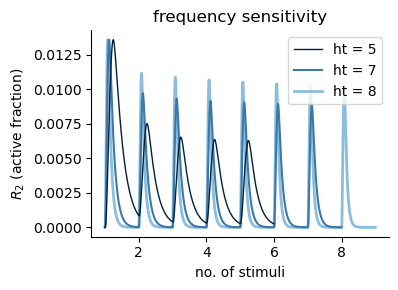

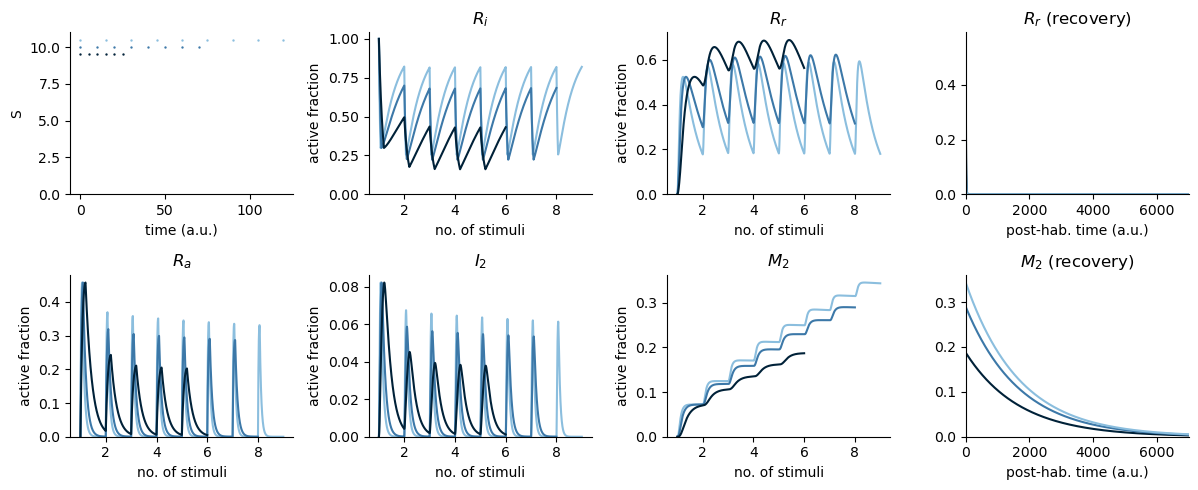

Intensity sensitivity
T 10 A 3 5 86.13
T 10 A 5 6 761.83
T 10 A 10 7 1320.95


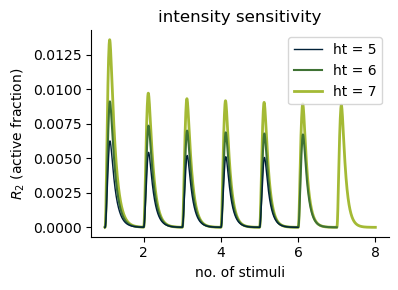

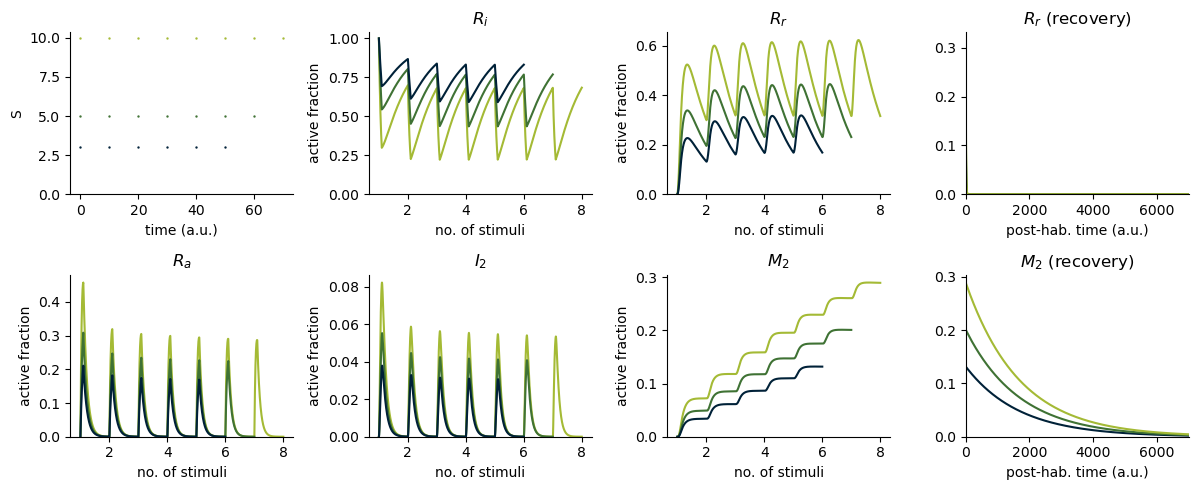

Potentiation
T 5 A 5


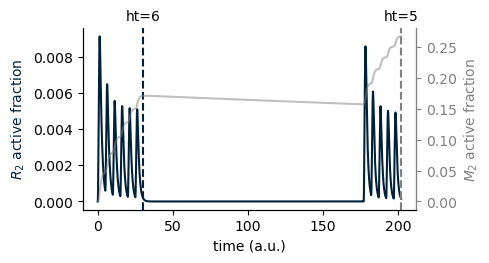

T 10 A 5


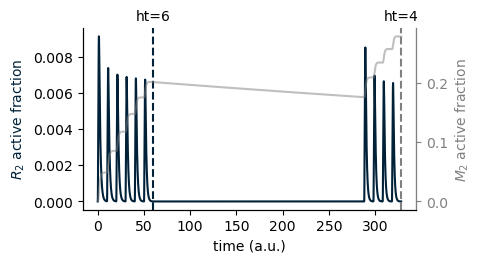

T 15 A 5


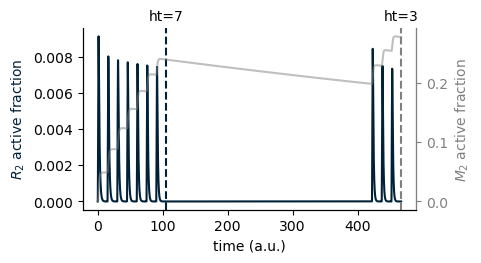

Subliminal
T 5 A 5


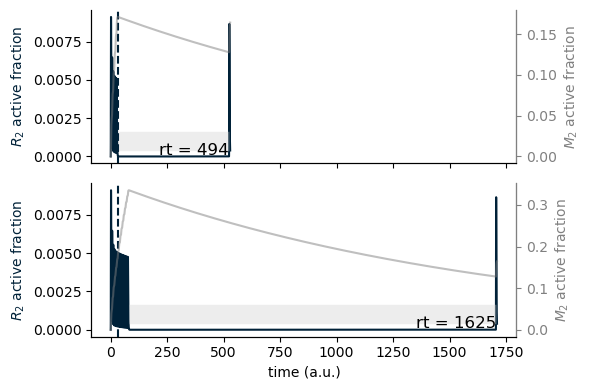

T 10 A 5


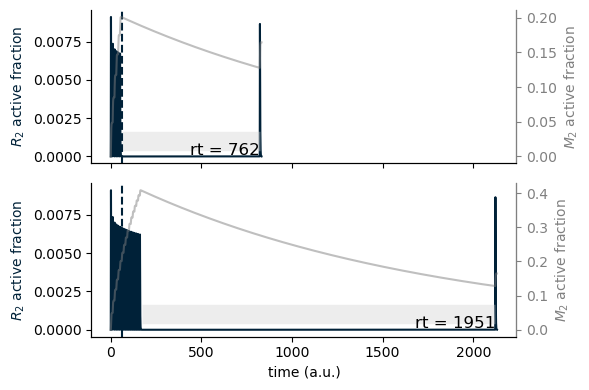

T 15 A 5


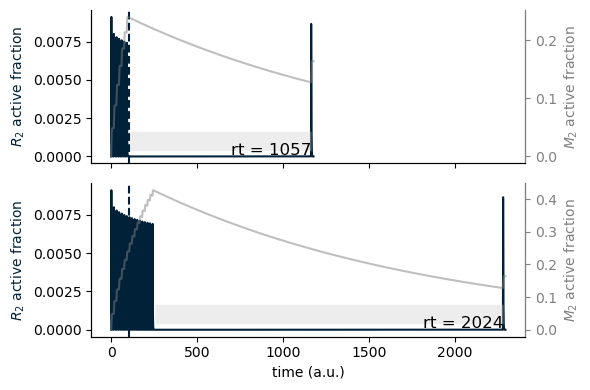

In [9]:
#with R2 as output node
def f_R_NF(X, t, S, k1, k2, k3, kMa, kIa2, kIi2, kRa2, kRi2, kMa2, kMi2):
    # starting values
    Ri, Rr, Ra, I2, M2, R2 = X

    dRi  = k3*Rr - k1*S*Ri
    dRr = k2*Ra + kMa*M2*Ra - k3*Rr 
    dRa = S*k1*Ri - k2*Ra - kMa*M2*Ra
    dI2 = kIa2*Ra*(1-I2) - kIi2*I2
    dR2 = kRa2*I2*(1-R2) - kRi2*R2
    dM2 = kMa2*R2*(1-M2) - kMi2*M2
    
    return(dRi, dRr, dRa, dI2, dM2, dR2)
# set parameters

idxs={"Ri":0, "Rr":1, "Ra":2, "I2":3, "M2":4, "R2":5}
#["I1", "M1", "R1", "I2", "M2"]
variables_toplot=["Ri","Rr","Ra","I2","M2"]
Ms_toplot=["Rr","M2"]

p0=[ 0.123610, 0.772732, 0.104607, 0.903910, 1.033100, 5.04596, 1.002160, 5.75706, 2.51961, 0.000594] #only rates and ODE parameters
Ton=1.0

Amin=0
            

T_scan_set=[5,10,15]
A_scan_set = [3, 5, 10]
Sfs=10
Tis=10


X0 = [1,0,0,0,0,0] 

steps_per_time = 100

#R2 the output 
idx_hab=5
mys = system.System(f_R_NF,p0, X0,output_var_idx=idx_hab,steps_per_time=steps_per_time,hmax=0)


folder="../../habituation/2023_paper/figs/panels"
basename="R_F"

if True:
    print("Frequency sensitivity")
    output = execute_freq_sens(mys,T_scan_set=T_scan_set,Amin=0, Amax=Sfs, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)

    namesave="%s_freqs.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_freq_or_is(*output,T_scan_set=T_scan_set, A_scan_set=[Sfs],varname="$R_2$",idx=idx_hab,
                          kind="freqs",colors=colorsf,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=savepath)

    namesave="%s_freqs_traj.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_trajectories(*output,idxs=idxs, T_scan_set=T_scan_set, A_scan_set=[Sfs], variables_toplot=variables_toplot,
                          Ms_toplot=Ms_toplot,kind="freqs",offsets=[0.95,1,1.05],colors=colorsf,steps_per_time=steps_per_time,
                      zorder=[3,2,1],xlimrec=7000,ylims=1.1*Sfs,savepath=savepath)
    #adjust xlimrec to look good

    print("Intensity sensitivity")
    output = execute_int_sens(mys,A_scan_set=A_scan_set,Amin=0,T=Tis, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)


    namesave="%s_ints.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_freq_or_is(*output,T_scan_set=[Tis], A_scan_set=A_scan_set,varname="$R_2$",idx=idx_hab,
                          kind="ints",colors=colorsi,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=savepath)

    namesave="%s_ints_traj.pdf"%basename
    savepath=os.path.join(folder,namesave)
    plot_trajectories(*output,idxs=idxs, T_scan_set=[Tis], A_scan_set=A_scan_set,variables_toplot=variables_toplot,
                          Ms_toplot=Ms_toplot,kind="ints",colors=colorsi,steps_per_time=steps_per_time,
                      zorder=[3,2,1],xlimrec=7000,ylims=None,savepath=savepath)

print("Potentiation")
for T in T_scan_set:
    for A in A_scan_set[1:]:
        print("T", T, "A", A)
        rtf=0.3
        namesave="%s_pot_%g_T=%g_A=%g.pdf"%(basename, rtf, T, A)
        savepath=os.path.join(folder,namesave)
        
        potentiation(f_R_NF,p0,X0,varname_R="$R_2$", varname_M="$M_2$",idxR=idx_hab,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,ht_threshold=0.01,recovery_threshold=0.95,
                         steps_per_time=steps_per_time,rt_fraction=rtf,savepath=savepath,color=colorsf[0])
        break
print("Subliminal")
for T in T_scan_set:
    for A in A_scan_set[1:]:
        print("T", T, "A", A)
        namesave="%s_sub_T=%g_A=%g.pdf"%(basename, T, A)
        savepath=os.path.join(folder,namesave)

        subliminal(f_R_NF,p0,X0,varname_R="$R_2$", varname_M="$M_2$",idxR=idx_hab,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,
                   ht_threshold1=0.01,ht_threshold2=0.005,recovery_threshold=0.95,
                    steps_per_time=steps_per_time,savepath=savepath,color=colorsf[0])

        break

# Single feedforward

T 5 A 4.51 18 109.1
T 5 A 9.02 20 118.08
T 5 A 13.52 22 122.3


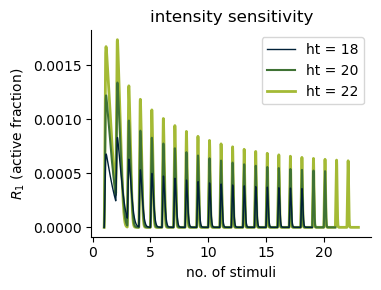

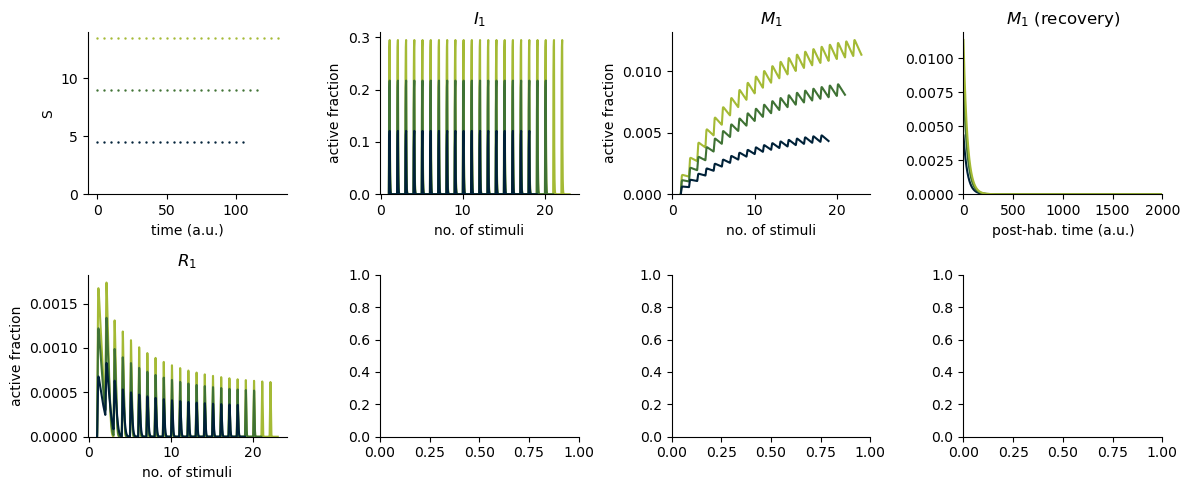

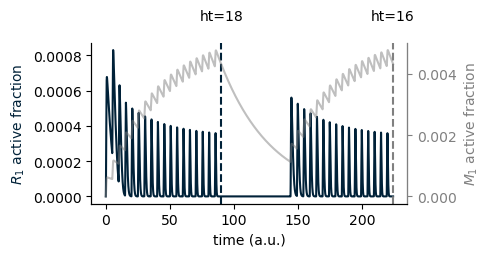

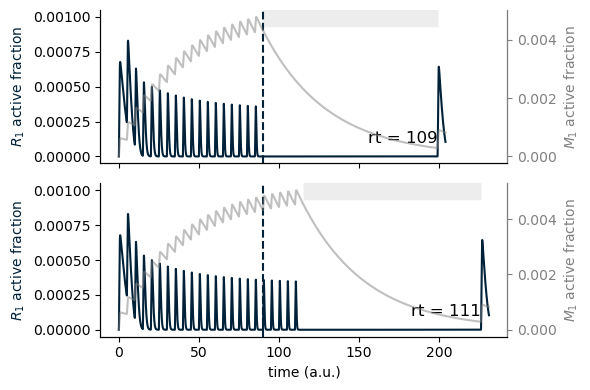

In [10]:
def f_IFF1(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1): 
    # starting values 
    I1, M1, R1 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = I1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)

    return(dI1, dM1, dR1)
# set parameters
 
idxs={"I1":0, "M1":1, "R1":2}

p0=[ 0.21431239109526712, 6.847671424297533, 0.009953498338965153 , 0.024876350255001917, 
    0.011779374058405177, 0.30, 0.0002789402845197418] #only rates and ODE parameters
Ton= 0.5
Amin=0

T_scan_set=[5]
A_scan_set = [4.51, 9.02, 13.52]


X0 = [0,0,0] 

labels=[r"$I_1$", r"$M_1$", r"$R_1$"] #should match order in X0

mys = system.System(f_IFF1,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)

#output = execute_freq_sens(mys,T_scan_set=T_scan_set,Amin=0, Amax=Sfs, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)

#plot_freq_or_is(*output,T_scan_set=T_scan_set, A_scan_set=[Sfs],varname="$R_2$",idx=-1,
#                      kind="freqs",colors=colorsf,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=None )

#plot_trajectories(*output,idxs=idxs, T_scan_set=T_scan_set, A_scan_set=[A_scan_set[0]], 
#                      kind="freqs",offsets=[0.95,1,1.05],colors=colorsf,steps_per_time=steps_per_time,
#                  zorder=[3,2,1],xlimrec=2000,ylims=11,savepath=None)
output = execute_int_sens(mys,A_scan_set=A_scan_set,Amin=0,T=T_scan_set[0], Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)
plot_freq_or_is(*output,T_scan_set=T_scan_set, A_scan_set=A_scan_set,varname="$R_1$",idx=-1,
                kind="ints",colors=colorsi,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=None )

plot_trajectories(*output,idxs=idxs, T_scan_set=[T_scan_set[0]], A_scan_set=A_scan_set, 
                      kind="ints",colors=colorsi,steps_per_time=steps_per_time,
                  zorder=[3,2,1],xlimrec=2000,ylims=None,savepath=None)

rtf=0.5
A=4.5
T=5
potentiation(f_IFF1,p0,X0,varname_R="$R_1$", varname_M="$M_1$",idxR=-1,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,ht_threshold=0.01,recovery_threshold=0.95,
                         steps_per_time=steps_per_time,rt_fraction=rtf,savepath=None,color=colorsf[0])


    
subliminal(f_IFF1,p0,X0,varname_R="$R_1$", varname_M="$M_1$",idxR=-1,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,
           ht_threshold1=0.01,ht_threshold2=0.005,recovery_threshold=0.95,
            steps_per_time=steps_per_time,savepath=None,color=colorsf[0])

# Single feedback

T 5 A 2 7 100.12
T 5 A 4.5 8 108.32
T 5 A 9.0 9 113.67


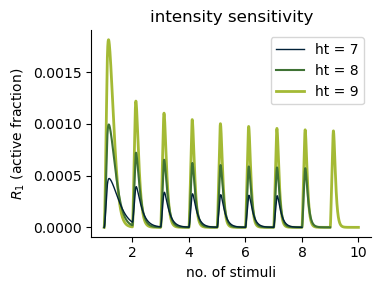

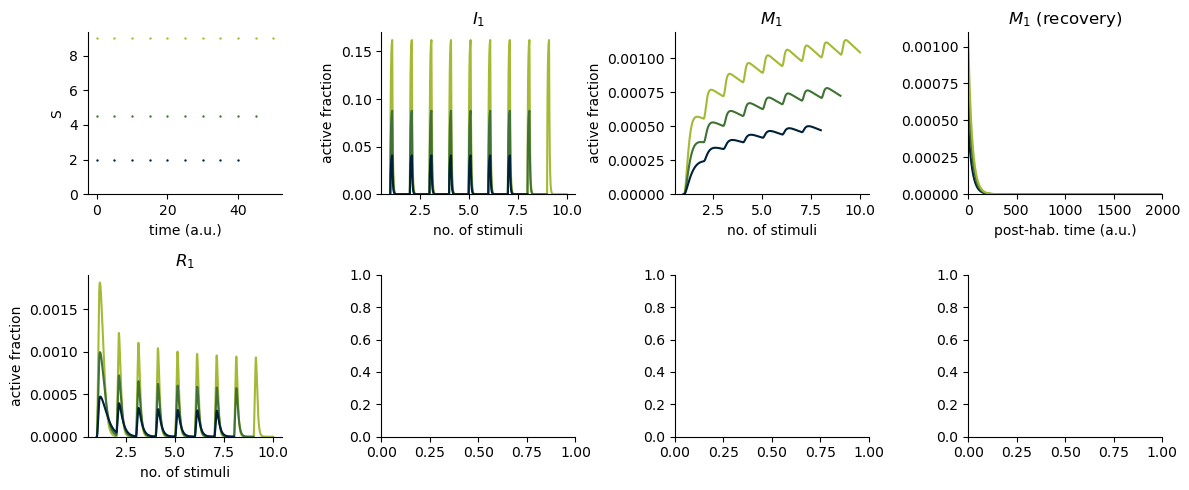

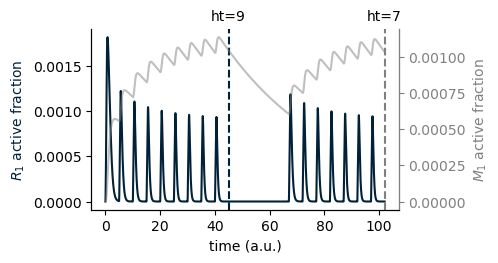

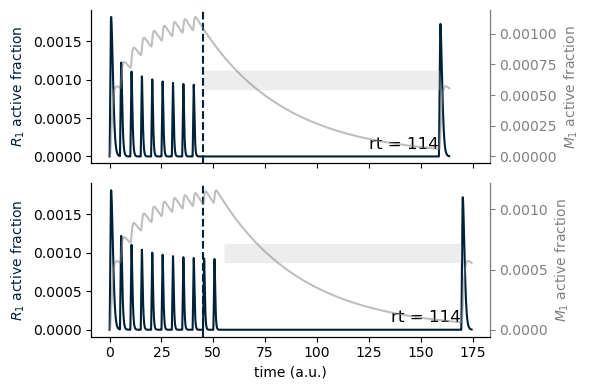

In [11]:
def f_NF(X, t, S, kIa1, kIi1, kMa1, kMi1, kRa1, kRi1, K_1): 
    # starting values 
    I1, M1, R1 = X
    # ODEs
    dI1 = S*kIa1*(1.0-I1) - kIi1*I1
    dM1 = R1*kMa1*(1.0-M1) - kMi1*M1
    dR1 = I1*kRa1*(1.0-R1) - M1*kRi1*R1/(K_1+R1)
    
    return(dI1, dM1, dR1)

p0=[ 0.15, 6.847671424297533, 0.21431239109526712 , 0.024876350255001917, 
    0.023558748116810354, 9.0, 0.002789402845197418] #only rates and ODE parameters
Ton= 0.5
Amin=0


X0 = [0,0,0] 

labels=[r"$I_1$", r"$M_1$", r"$R_1$"] #should match order in X0
idxs={"I1":0, "M1":1, "R1":2}
A_scan_set = [ 2,4.5,9.0]
T_scan_set=[5]

mys = system.System(f_NF,p0, X0,output_var_idx=-1,steps_per_time=100,hmax=0)

#output = execute_freq_sens(mys,T_scan_set=T_scan_set,Amin=0, Amax=Sfs, Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)

#plot_freq_or_is(*output,T_scan_set=T_scan_set, A_scan_set=[Sfs],varname="$R_2$",idx=-1,
#                      kind="freqs",colors=colorsf,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=None )

#plot_trajectories(*output,idxs=idxs, T_scan_set=T_scan_set, A_scan_set=[A_scan_set[0]], 
#                      kind="freqs",offsets=[0.95,1,1.05],colors=colorsf,steps_per_time=steps_per_time,
#                  zorder=[3,2,1],xlimrec=2000,ylims=11,savepath=None)
output = execute_int_sens(mys,A_scan_set=A_scan_set,Amin=0,T=T_scan_set[0], Ton=Ton,ht_threshold=0.01, recovery_threshold=0.95)
plot_freq_or_is(*output,T_scan_set=T_scan_set, A_scan_set=A_scan_set,varname="$R_1$",idx=-1,
                kind="ints",colors=colorsi,steps_per_time=steps_per_time,zorder=[3,2,1],savepath=None )

plot_trajectories(*output,idxs=idxs, T_scan_set=[T_scan_set[0]], A_scan_set=A_scan_set, 
                      kind="ints",colors=colorsi,steps_per_time=steps_per_time,
                  zorder=[3,2,1],xlimrec=2000,ylims=None,savepath=None)

rtf=0.2 #note in this case it is smaller
A=9
T=5
potentiation(f_NF,p0,X0,varname_R="$R_1$", varname_M="$M_1$",idxR=-1,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,ht_threshold=0.01,recovery_threshold=0.95,
                         steps_per_time=steps_per_time,rt_fraction=rtf,savepath=None,color=colorsf[0])


    
subliminal(f_NF,p0,X0,varname_R="$R_1$", varname_M="$M_1$",idxR=-1,idxM=-2,T=T,Ton=Ton,Amin=0,Amax=A,
           ht_threshold1=0.01,ht_threshold2=0.005,recovery_threshold=0.95,
            steps_per_time=steps_per_time,savepath=None,color=colorsf[0])